# (Fun With) Driver-Mode Detection
#### Jonathan D. Jarvis, Ph.D.
-----
>*“The one thing that unites all human beings, regardless of age, gender, religion, economic status, or ethnic background, is that, deep down inside, we all believe that we are above-average drivers.”  - Dave Barry*

-----

This notebook explores the concept of driver-mode detection (DMD) for evolving user-based-insurance (UBI) paradigms, such as pay-how-you-drive (PHYD).  

UBI has a wide variety of potential benefits for both insurance providers and policy holders.  Every insurance market is fundamentally concerned with the characterization of a (typically) high-dimensionality risk space.  Modern UBI provides an oportunity to tighten the predictive distributions that characterize customer bases and yield more efficient, predictable and granular valuation of the underlying risk.  UBI systems typically involve the analysis of a datastream that may include kinematics of the vehicle; trip properties, such as location, origin, destination, time of day, observance of speed limits; and indications of specific practices, such as distracted driving.  Some UBI systems rely on an on-board-diagnostics (OBD) interface for  some or all of this datastream, which may involve additional materials and maintenance costs for the insurance provider.  

There is a concerted effort in the industry to augment or obviate this OBD component through the use of various meta data and the intertial-measurement-unit (IMU) sensors and GPS receivers that are available in nearly every modern smartphone.  A typical IMU consists of three principal components: an accelerometer, a gyroscope and a magnetometer; each of these sensors reports 3-axis data in the local reference frame of the phone.  The quality of the accelerometer and gyroscope is insufficient for high-precision inertial navigation/analysis; however, with standard sensor-fusion techniques and modern developments in machine learning, important insights may be derived from the datastream.

In order for these data to be useful in PHYD, we need to determine whether a policy holder, on whose phone the client-side PHYD software is running, is the driver of a vehicle or is a passenger sitting a mere half-meter away.  We need to develop a rich feature space in which instances of this "driver-mode" may be effectively classified and delineated from instances of "passenger-mode".  To that end, this preliminary notebook proposes, and begins to implement, various analyses that may find utility in driver-mode detection.

-----
## Imports
-----

In [1]:
%matplotlib inline

from IPython.display import display, HTML
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation
from matplotlib.pylab import rcParams
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from scipy.interpolate import griddata
from scipy import signal
from sklearn import cluster
from sklearn import metrics
from sklearn.metrics import silhouette_score
from time import time

import pandas as pd
import numpy as np
import numpy.random as npr
import quaternion
import statsmodels.api as sm
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import glob
import os.path

warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 10, 10
#mpl.use('GTKAgg') #helpful for speeding up animation functionality

-------
## Function Definitions
-----

In [2]:
#######################
## Utility functions ##
#######################

def num_missing(x):
    
    return sum(x.isnull())


def mask(df,tb,te):
    
    return (df.index > tb) & (df.index < te)


def interpolate_delta(df, inplace=False):
    #http://stackoverflow.com/questions/34315753/cannot-interpolate-in-pandas-dataframe
    
    if not inplace:
        df = df.copy()
    ind = df.index
    df.index = df.index.total_seconds()
    df.interpolate(method="index", inplace=True)
    df.index = ind
    return df


def reg_data(df, base='1L', grid='20L'):
    # This function takes an input dataframe whose time data (labeled "time") 
    # is numeric seconds (either in the index or in a column), downsamples to a given time base ('base'),
    # interpolates the missing values, and then resamples to a slower time base (grid)
    # This function was designed, narrowly, to condition data from cellphone IMUs
    # Its use requires the function interpolate_delta, which is given above, to handle an index-assignment bug
    
    dfa = df.copy().reset_index()
    dfa['datetime'] = (dfa.time * 1e9).astype('timedelta64[ns]')
    dfa.drop('time', axis=1, inplace=True)
    dfa = dfa.set_index('datetime')
    dfa= dfa.resample(base, how="mean")
    dfa = interpolate_delta(dfa, inplace=True)
    dfa = dfa.resample(grid, how = "mean")
    
    return dfa


def dataprep(tstart,tstop,df):
    #Windows input dataframe with a start and stop time and generates the corresponding time differentials
    #using the index values; outputs numpy arrays
    
    D = df[(df.index > tstart) & (df.index < tstop)]
    t = D.index.values
    ts = np.roll(t,-1)
    D = D.values[:-1]
    dt = (ts - t)[:-1,None]
    return D,dt


def figprep(az=45, el=30):
    #simple fig template for reducing clutter
    
    fig = plt.figure()
    ax = plt.subplot(111, projection='3d')
    
    ax.set_xlim3d(-1,1)
    ax.set_ylim3d(-1,1)
    ax.set_zlim3d(-1,1)

    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.patch.set_facecolor('white')

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    ax.azim = az
    ax.elev = el
    
    return ax, fig


#Handy class & function for plotting 3D vectors with arrowheads
#borrowed from:  http://stackoverflow.com/questions/22867620/putting-arrowheads-on-vectors-in-matplotlibs-3d-plot
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


def draw_axes(axis, vecs, size, allblack=False):
    colors = ['g', 'b', 'r']
    if not allblack:
        for idx, v in enumerate(vecs):
            art = Arrow3D([0,v[0]],[0,v[1]],[0,v[2]], mutation_scale=size, lw=2, arrowstyle="-|>", 
                          color=colors[idx])
            axis.add_artist(art)
    else:
        for idx, v in enumerate(vecs):
            art = Arrow3D([0,v[0]],[0,v[1]],[0,v[2]], mutation_scale=size, lw=2, arrowstyle="-|>", 
                          color='k')
            axis.add_artist(art)
    return()

################################
##Quaternion-related functions##
################################

def rot_nquat(a,theta):
    #computes a quaternion that specifies a rotation of 'theta' radians about the axis 'a';
    #requires quaternion module
    
    nvec = a/np.linalg.norm(a)
    pvec = np.sin(theta/2)*nvec
    
    return np.quaternion(np.cos(theta/2),pvec[0],pvec[1],pvec[2])


def R_nquat(a,dt):
    #a is an mx3 array that contains the unnormalized angular velocity components for each update (rad/sec)
    #dt is an mx1 vector that contains the dt values between that datapoint and the next
    #The rotation angle for the quaternions is given by the magnitude of each row in 'a' times dt;
    #requires quaternion module
    
    if np.size(a) > 3:
        amag = np.linalg.norm(a,axis=1)
        alpha = amag*dt[:,0]/2
        anorm = a/amag[:,None]
        b = np.lib.pad(anorm,((0,0),(1,0)), 'constant', constant_values = 0)
        b = b*np.sin(alpha)[:,None]
        b[:,0] = np.cos(alpha)
        qb = quaternion.as_quat_array(b)
    else:
        amag = np.linalg.norm(a)
        anorm = a/amag
        alpha = amag*dt/2
        b = np.sin(alpha)*anorm
        qb = np.quaternion(np.cos(alpha),b[0],b[1],b[2])
    
    return qb


def pure_quat(a):
    #a is an mx3 array of floats.  Each row vector is recast as a pure quaternion; requires quaternion module
    
    if np.size(a) > 3:
        b = np.lib.pad(a,((0,0),(1,0)), 'constant', constant_values = 0)
        qb = quaternion.as_quat_array(b)
    else:
        qb = np.quaternion(0,a[0],a[1],a[2])
    
    return qb


def rotate_vec(q,p,reverse=False):
    #Wrapper for a properly normalized quaternion rotation; requires quaternion module
    if not reverse:
        a = q*p*np.conjugate(q)
    else:
        a = np.conjugate(q)*p*q
  
    return a

def rand_rot_walk(ipos,wavg,wamp,Nt,tstep,reverse=False):
    #This function generates a random walk through rotation space for the purpose of testing the quaternion
    #functionality.  'ipos' is the initial orientation 3-vector, 'wavg' is a 3-vector specifying an average
    #drift, 'wamp' is a scalar value specifying the scale parameter of the gaussian noise (equal in each dim),
    #Nt is the desired number of timesteps and tstep is the step size.  The angle subtended by the
    #rotation during that step is given by the magnitude of the randomly generated vector 'rot' 
    #(which changes every timestep) times 'tstep'; requires quaternion module
    
    pos = quaternion.as_quat_array(np.empty([Nt+1,4]))
    dt = np.ones((Nt,1))*tstep
    rot = npr.normal(0,wamp,(Nt,3)) + wavg
    qrot = R_nquat(rot,dt)
    pos[0] = np.quaternion(0,ipos[0],ipos[1],ipos[2])
    
    for i,row in enumerate(qrot):
        pos[i+1] = rotate_vec(row,pos[i],reverse)
    
    pts = quaternion.as_float_array(pos)
    
    return pts[:,1:] 


def gyro_walk(ipos, gyro, dt, reverse=False):
    #This function uses quaternions to perform rotations of an initial vector 'ipos'.  It requires 
    #3-axis rate gyro data ('gyro'), in rad/sec, and a matching mx1 vector of time differentials between 
    #adjacent points; requires quaternion module
    
    Nt = np.size(dt)
    pos = quaternion.as_quat_array(np.empty([Nt+1,4]))
    qrot = R_nquat(gyro,dt)
    pos[0] = np.quaternion(0,ipos[0],ipos[1],ipos[2])
    
    for i,row in enumerate(qrot):
        pos[i+1] = rotate_vec(row,pos[i], reverse)
    
    pts = quaternion.as_float_array(pos)
    
    return pts[:,1:] 


def gyro_walk_c(ipos, gyro, acc, dt, eps_grav=0.05, eps_gyro=0.2, alpha=0.1, filt=True, g=9.81):
    #This function uses quaternions and the provided gyro data to encode and rotate the orientation of 
    #the sensor frame within the inertial frame; furthermore, it performs includes sensor fusion with 
    #the provided accelerometer data, via a complementary filter, to correct tilt error in the gyro integration  
    #REQUIRES: 3-axis rate gyro data ('gyro'), in rad/sec, and a matching mx1 vector of time 
    #differentials between adjacent points; requires quaternion module
    z_axis = np.array([0,0,1.]) 
    
    #generating a toggle mask for complementary filtering based on gyro and acc. readings
    acc_mag = np.linalg.norm(acc,axis=1)
    gyro_mag = np.linalg.norm(gyro, axis=1)
    filt_toggle = (np.absolute(acc_mag - g)/g < eps_grav) & (gyro_mag < eps_gyro) & filt
    filt_frac = np.mean(filt_toggle) if filt else 0
    
    Nt = np.size(dt)
    pos = quaternion.as_quat_array(np.empty([Nt+1,4]))
    Q = quaternion.as_quat_array(np.empty([Nt+1,4]))
    dq = R_nquat(gyro,dt)
    Q[0] = np.quaternion(1., 0, 0, 0)
    pos[0] = np.quaternion(0,ipos[0],ipos[1],ipos[2])
    
    #acc to pure quats
    acc = np.lib.pad(acc,((0,0),(1,0)), 'constant', constant_values = 0)
    acc_quat = quaternion.as_quat_array(acc)
    
    for i,row in enumerate(dq):
        pos[i+1] = Q[i]*pos[0]*np.conjugate(Q[i])
        Q[i+1] = Q[i]*row
        
        #check datapoint against filter conditions; if met then apply complementary filtering
        if filt_toggle[i]:
            acc_quat_inertial = Q[i]*acc_quat[i]*np.conjugate(Q[i]) #convert acc to inertial coords
            v = quaternion.as_float_array(acc_quat_inertial)[0,1:]
            v_norm = v/np.linalg.norm(v)
            
            #cross product to get corrective axis and dot to get angle
            vz_cross = np.cross(v_norm,z_axis)          
            vz_cross_norm = vz_cross/np.linalg.norm(vz_cross)
            vz_dot = np.dot(v_norm, z_axis)
            phi_tilt = np.arccos(vz_dot)
            
            #generate quaternion for tilt-error correction
            tilt_quat = rot_nquat(vz_cross_norm, (1-alpha)*phi_tilt)
            
            Q[i+1] = tilt_quat*Q[i+1]
            
    pts = quaternion.as_float_array(pos)
    
    return pts[:,1:], Q, filt_frac 


def mat_rot(v,theta):
    #simple rotation about the z-axis for diagnostic purposes
    M = np.array([[np.cos(theta), -np.sin(theta), 0],[np.sin(theta), np.cos(theta), 0],[0, 0, 1]])
    return M.dot(v)


##############################
##ML and filtering functions##
##############################
    
def km_stats(estimator, name, data, ss, Nc):
    #modified helper function from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html
    t0 = time()
    estimator.fit(data)
    tf = time()
    print('% 9s  %i   %.2fs    %i   %.3f'
          % (name, Nc, (tf - t0), estimator.inertia_,
             metrics.silhouette_score(data, estimator.labels_, metric='euclidean', sample_size=ss)))
    return()

def butter_dig(fcut, fsamp, ftype='high', order=3):
    #http://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
    fnyq = 0.5 * fsamp
    fcut_n = fcut / fnyq
    b, a = signal.butter(order, fcut_n, btype=ftype, analog=False)
    return b, a

def butter_filter(data, fcut, fsamp, ftype, order=5):
    #wrapper for applying digital-butterworth-filter function to multiple colummns
    b, a = butter_dig(fcut, fsamp, ftype, order=order)
    y = np.zeros(np.shape(data.T))
    
    for i,col in enumerate(data.T):
        y[i] = signal.filtfilt(b, a, col)
    return y.T

def filter_data(df, tb, te, tbase_interp=1, tbase_resamp=20, order=5, fcutoff=0.33, ftype='high'):
    #tbase_interp and t_base_resamp are given in milliseconds and the function expects a dataframe containing
    #x,y,z data for a sensor.  The index column is the timestamp in 
    
    df_copy = df.copy()
    df_copy = df_copy[mask(df_copy,tb,te)]
    ti_str = str(tbase_interp)+'L'
    tr_str = str(tbase_resamp)+'L'
    df_reg = reg_data(df_copy, ti_str, tr_str)
    
    tb_t = dt.timedelta(seconds=tb)
    te_t = dt.timedelta(seconds=te)
    data_num,dtvec = dataprep(tb_t,te_t,df_reg)
    dtvec = dtvec/np.timedelta64(1, 's')

    tvec = np.cumsum(dtvec) + tb - dtvec[0]
    
    fsamp = 1/(tbase_resamp*1.e-3)
    
    y = butter_filter(data_num, fcutoff, fsamp, ftype, order)
    
    return y, tvec, data_num, dtvec


# Concept and Approach
Every so often, people move really fast for an extended period of time.  If you are a company that insures that person's vehicles, then you'd like to know more.  There are two principal questions that encapsulate the event: what do we know about the person taking this trip, and what are the accessible data they generated in the process?  We can extend our contextual understanding of this information by considering a large ensemble of trips, by a large number of individuals, and any *a priori* domain expertise we have regarding the general properties of trips.  All these data constitute a distribution across a vast parameter space.  The universe is effectively sampling from this distribution every day in a effort to make our commutes interesting.

Using clever admixtures of features and analyses we could separate trips by the mode of transportation: motor vehicle, rail-systems, aircraft, cycling etc...  For example, rail systems would tend to have very prescriptive conditions (according to railway maps) for a trip's geographic path.  Aircraft would tend to have  high average speed, low barometric pressure/high altitude, a general lack of respect for the directionality of road and rails, and in some cases, well known and highly constrained geographic endpoints (airports/helipads).  Cycling would register below average speeds and have distinct spectral signatures in IMU data due to the periodic cadence of pedaling.  Motor vehicle trips would show strong geographic coherence with roads; temporal coherence with traffic signals; general adherence to known speed limits, depending on road type; and responsiveness to real-time maps of traffic congestion.
       
All of the example features described thus far are completely anonymized, but we can also consider a rich subspace of behavioral data generated by a given individual both in a single trip and over their entire history of trips.  Let's presuppose that by using some of the aforementioned features, we've built a classifier that has successfully conditioned our vast dataset of trips according to whether or not they were in a motor vehicle.  In probabalistic terms, we are now considering the conditional distribution $P(\vec{\theta}\mid motor\:vehicle)$, where $\vec{\theta}$  is a large feature vector incorporating all the data/information we've discussed.  Again, this runs the gamut from the kinematic data stream of the IMU/GPS unit in the individual's cellphone to any personal-profile information we have for the individual (age, gender, marital status, ethnicity, home/work address, ~miles/yr, # of children).  Every trip in this conditional distribution can be classified as one of two types: "driver-mode" or "passenger-mode."  Our goal is to build a machine-learning pipeline that dilineates these classes with high accuracy, without the use of data from an OBD device.

<img align="right" src="http://i.imgur.com/Zz2Xd7A.png" title="Fig. 1: Example driver-mode-detection pipeline" width="400">

The data we've described here has a wide range of numerical and categorical components; decision forests are a flexible and powerful family of tree-based classifiers that are well suited for such a problem space.  Decision forests combine a large number of decision trees via some ensemble prediction method.  These constituent decision trees are "weak learners" in that they are not designed/expected to deliver low generalization error on their own; however, if the trees have even slightly better than random accuracy, then a large ensemble of uncorrelated trees can produce a highly accurate consensus decision.  This is accomplished by the inclusion of one or more stochastic elements in the training procedure, most typically bootstrap aggregation (bagging) and/or random-subspace methods.  In bagging, each tree is trained on a small subset of the available training data.  These subsets comprise points sampled from the training data with replacement (i.e. some points from the full training set may appear in a given subset multiple times).  Random-subspace methods involve the use of a random subset of features at each node in the tree.  The combination of bagging and subspace randomization is specifically known as a random forest.  A relatively comprehensive introduction is given in [1].

<img align="right" src="http://i.imgur.com/b5JUiiP.png" title="Fig. 2: Anroid-API coordinate system">

In the absence of an actual database of drivers and trips, we will have to focus largely on feature development using sample IMU data.  In this notebook we consider data from a single Android device, specifically a Samsung Galaxy S5.  The coordinate system for the body frame of the phone is shown in figure 2.  The 3-axis accelerometer reports acceleration in $\mathrm{m/s^{2}}$; note that the sensor will measure the normal-force exerted on the device while it is stationary.  This will allow us to use gravity's quasi-static vector field  to partially calibrate and error correct our gyro data and help project trip structure into orientation space.  The MEMS rate gyro reports a 3-vector of instantaneous angular velocities, $\mathrm{rad/s}$, with positive values being in the righ-handed sense (CCW) about each axis.  For purposes of illustration, we'll describe our feature development approach in pieces as we work through our sample data. 

Before we begin looking at IMU data, it's important to note that our cellphones may generate a variety of non-kinematic/geographic related signals that are discriminative for DMD.  For example, how often do you plug your phone into a charger when you are driving vs. riding as a passenger?  If you are a passenger in someone else's vehicle, the odds of plugging in are probably markedly lower.  Same question, but this time consider bluetooth or USB connection to the car and the registration of events from buttons on the steering column.  A large ensemble of even mildly discriminative features can help provide robust classification, so it's important to be on the look out for subtle behavioral events like this that we can include.

[1] https://www.microsoft.com/en-us/research/publication/decision-forests-for-classification-regression-density-estimation-manifold-learning-and-semi-supervised-learning/

-----

## Import data

-----

Suppose you noticed your neighbor doing the following at 22:30 in the evening:

    for i in range(7):
        1) Comes out of garage carrying cellphone
        2) Gets in car and departs
        3) Returns five minutes later from the other direction
        4) Gets out of car and walks into garage
        5) Pokes at cell phone for 10 seconds  

Over the course of 7 trips, while recording the data from my cellphone's 9-axis IMU, I systematically explored the breadth of my typical driving habits.  I iterated through a variety of behaviors such as hand interactions (HI) of various duration, timing (relative to the car's kinematics; e.g. brief hand interaction while at a stop) and intensity; transplanting the phone from one typical position to another; resting the phone in various orientations and on different materials (leather, plastic, pant's pocket); placing the phone in locations with more or less magnetic noise (under the dash vs. in pocket); etc...

I've also recorded less-contrived trips during my daily routine and have made a point of being aware of potentially relevant "signals" for DMD.

In [3]:
#Importing acc,gyro,mag data files into a nested list of dataframes (one for each trip)
#Each element in the main list is a list of dataframes, where each dataframe corresponds to a single trip
#There is one element for each sensor type at the top level

dirlist = [r'C:\ML\DriverDetection\Acc', r'C:\ML\DriverDetection\Gyro', r'C:\ML\DriverDetection\Mag']
data = [] #format{acc, gyro, mag}
dkeys = []

for j, dir_name in enumerate(dirlist):
    dataFiles = glob.glob(dir_name + "/*.csv")
    data_df = []
    datakey = {}
    
    for i, file in enumerate(dataFiles):
        df = pd.read_csv(file,index_col='time')
        data_df.append(df)
        datakey[i] = os.path.splitext(os.path.basename(file))[0]
    
    data.append(data_df)
    dkeys.append(datakey)

#checking dataframes and trip dict
#print(dkeys, [[k.head(3) for k in x] for x in data], [[k.shape for k in x] for x in data])

In [4]:
#check data for null values
#print([[k.apply(num_missing, axis=0) for k in x] for x in data])

In [5]:
#checking data types
#display([[x.dtypes for x in k] for k in data])

## Basic raw IMU data visualization

The figures below show the time history of the accelerometer (top), gyroscope (middle) and magnetometer (bottom) for each trip in our sample dataset.

The data for trips 1-4 were taken on exactly the same route, with the same driving profile (speed, accelerations, etc..) over approximately the same duration.  Trip 5 is a 15-km drive with cellphone interaction that is consistent with my typical driving habits.  Trip 6 is a controlled test where the phone is stationary on a table for ~3.5 minutes.  We'll use this example later to demonstrate the importance of systematic drift in the gyro signal.

#### Trip #1: phone face up in driver's pocket (around the neighborhood)

total trip duration: 282.856 sec


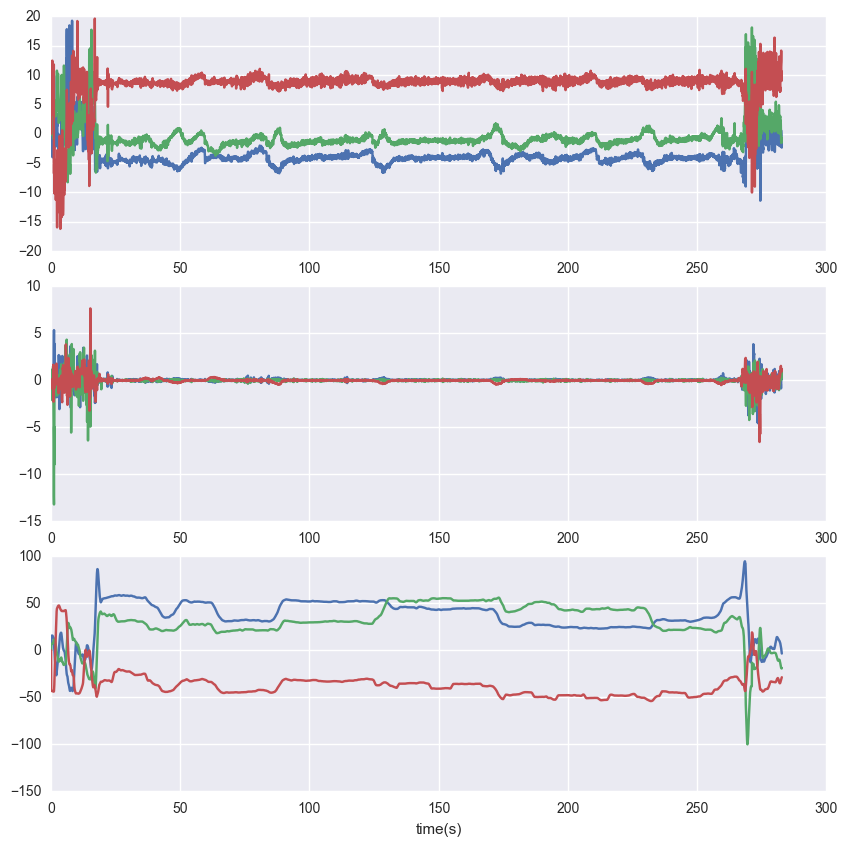

In [6]:
#trip 1
trip=1
for i in range(0,3):
    plt.subplot(3,1,i+1)
    plt.plot(data[i][trip-1])

plt.xlabel('time(s)')
plt.subplots_adjust(hspace=0.15)
print("total trip duration:" , data[i][trip-1].index[-1], 'sec')

#### Trip #2: phone face up, stationary under dash  (around the neighborhood)

total trip duration: 304.522 sec


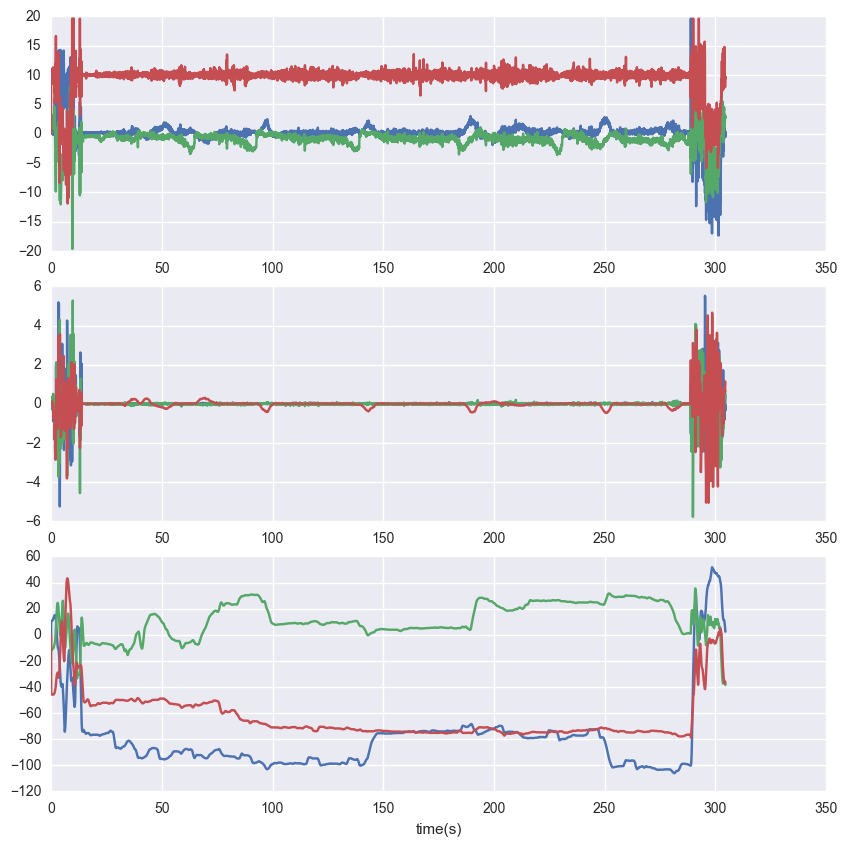

In [7]:
#trip 2
trip=2
for i in range(0,3):
    plt.subplot(3,1,i+1)
    plt.plot(data[i][trip-1])

plt.xlabel('time(s)')
plt.subplots_adjust(hspace=0.15)
print("total trip duration:" , data[i][trip-1].index[-1], 'sec')

#### Trip #3: phone face up in seat on passenger's side (around the neighborhood)

total trip duration: 325.132 sec


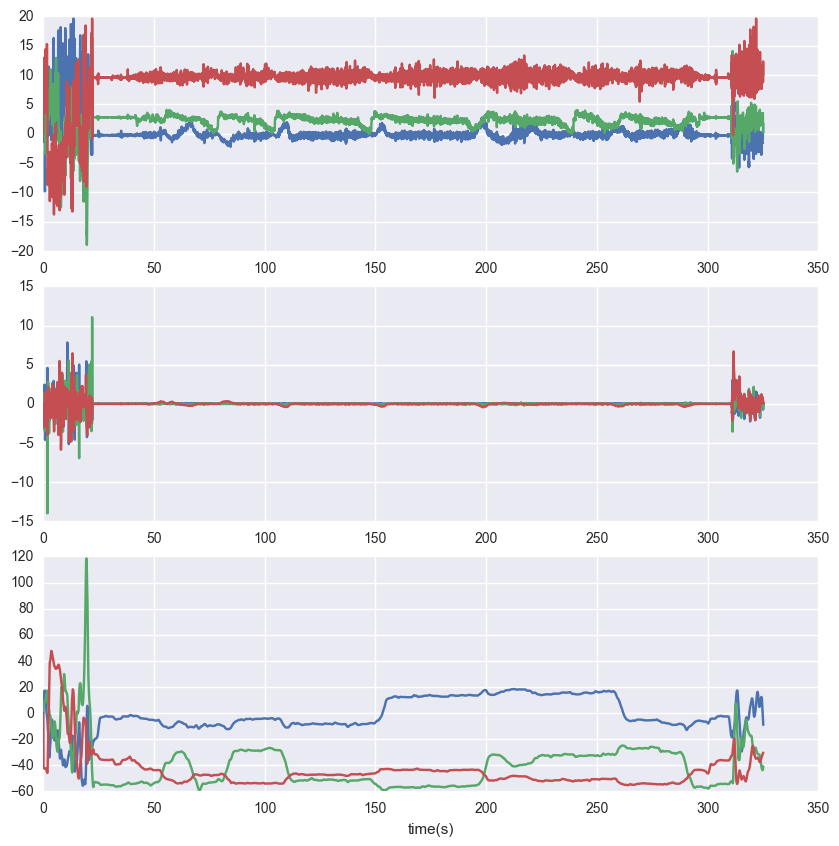

In [8]:
#trip 3
trip=3
for i in range(0,3):
    plt.subplot(3,1,i+1)
    plt.plot(data[i][trip-1])
    
plt.xlabel('time(s)')
plt.subplots_adjust(hspace=0.15)
print("total trip duration:" , data[i][trip-1].index[-1], 'sec')

#### Trip #4: Prodigious number of hand-interactions and transitions between typical resting positions (around the neighborhood)

total trip duration: 301.091 sec


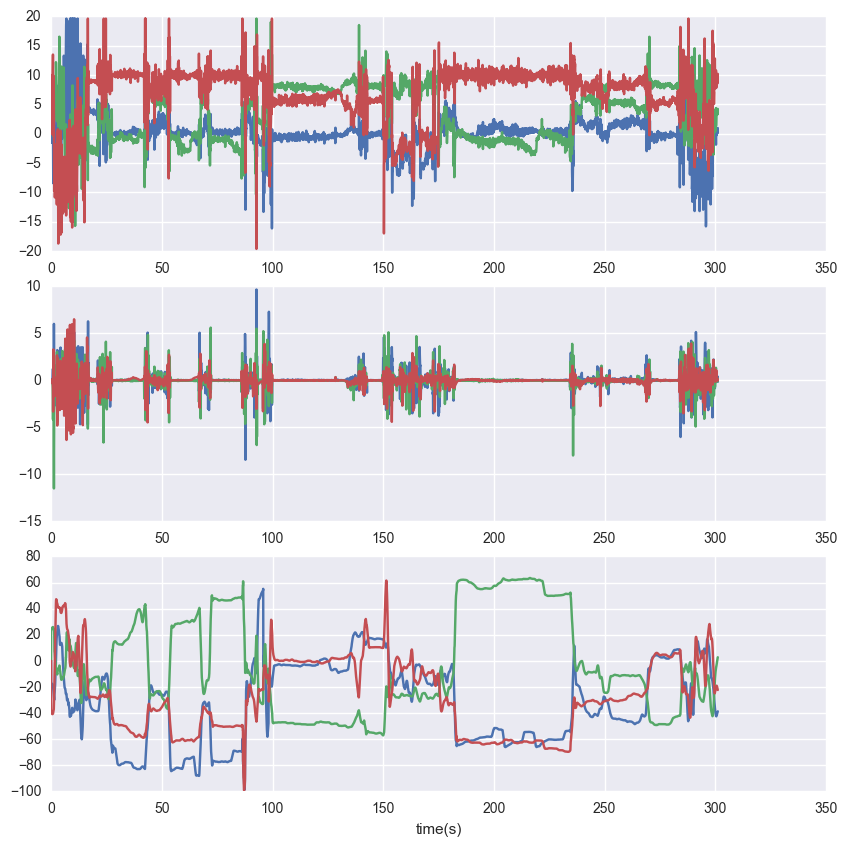

In [9]:
#trip 4
trip=4
for i in range(0,3):
    plt.subplot(3,1,i+1)
    plt.plot(data[i][trip-1])
    
plt.xlabel('time(s)')
plt.subplots_adjust(hspace=0.15)
print("total trip duration:" , data[i][trip-1].index[-1], 'sec')

#### Trip #5: Typical behavior during a roughly 15-km trip. Transitions between typical stationary locations

total trip duration: 877.55 sec


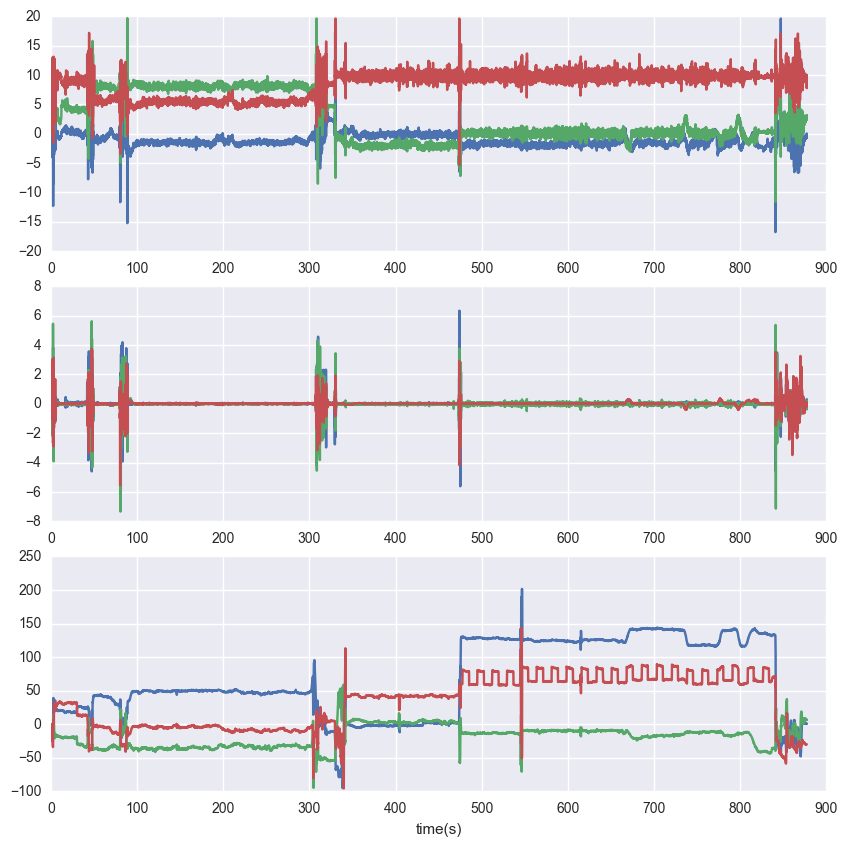

In [10]:
#trip 5
trip=5
for i in range(0,3):
    plt.subplot(3,1,i+1)
    plt.plot(data[i][trip-1])
    
plt.xlabel('time(s)')
plt.subplots_adjust(hspace=0.15)
print("total trip duration:" , data[i][trip-1].index[-1], 'sec')

#### Trip #6 is a controlled calibration test in which the phone was stationary on a table, undisturbed, for approximately 3.5 minutes.  We will use this trip as an example of the importance of systematic drift in the gyro signal. 

total trip duration: 210.148 sec


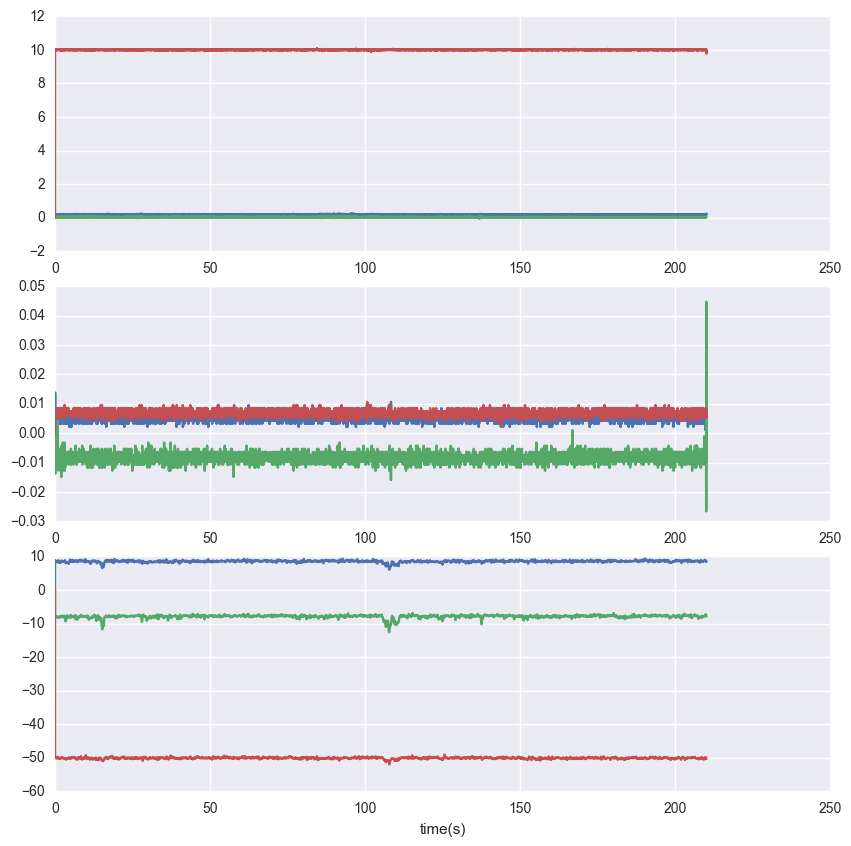

In [11]:
#trip 6: calibration test; ~200 sec flat on table and undisturbed
trip=6
for i in range(0,3):
    plt.subplot(3,1,i+1)
    plt.plot(data[i][trip-1])
    
plt.xlabel('time(s)')
plt.subplots_adjust(hspace=0.15)
print("total trip duration:" , data[i][trip-1].index[-1], 'sec')

### A comment on magnetometer data:

Incorporating magnetometer data into the analysis pipeline can present unique challenges.  Magnetometers are highly susceptible to environmental noise, such as stray magnetic fields from the car's electronic systems or even magnetic steel in the surrounding environment outside of the car.  For example, consider the protracted interference event, of unknown origin, shown below for trip #5.  Typically, magnetometer data is used for yaw correction (of the sensor frame within the inertial frame) in IMU sensor fusion applications; however, for the investigations we are conducting, the relative orientation of the phone within the car is of greater interest, and low-frequency movements about the yaw axis of the inertial frame (due to the vehicle turning, e.g.) can be filtered out.  

The magnetometer data may have utility as an ancillary confirmation signal for HI events.  Alternatively, the power spectrum of the magnetometer noise may give indications as to its proximity to electromagnetic interference (EMI) sources such as the dash area; nevertheless, we will largely ignore it for the purposes of this preliminary investigation.  

-----
# What does your cellphone experience during a drive/ride?

When I'm driving, my phone experiences light use, typically at traffic signals, and tends to transition between three or four common locations; e.g. under the dash, in the cup holder, between my legs, and more rarely on the passenger seat.  The distribution of these locations is highly dependent on whether I'm driving or not.  The beginning and end of HI events are straightforward to detect using IMU data.  At the beginning of an event, the rate-gyro and output transitions from a quienscent state to one with both high amplitude and high variance; conclusion of the HI event is marked by a transition back to the quiescent state.  The speed information derived from the gps datastream can be correlated in time with HI events.  If HIs on a trip tend to be concurrent with the vehicle's speed being approximately zero (as at a stop sign or traffic signal), then the probability of this being a driver-mode trip is likely higher.  High-frequency noise in the accelerometer signal can also be used as a proxy for vehicle movement.

Recall that the accelerometer is measuring a linear combination of three signals: any acceleration produced by the vehicle (acceleration, braking, turning, movement over uneven terrain), those from hand-interactions and the constant acceleration due to gravity.  When the phone is stationary in the rest frame of a vehicle and there are no additional accelerations, the accelerometer signal is dominated by gravity and the possible orientations of the phone (in the inertial frame of reference) comprise a cone whose axis is a vector in the gravity field.  It's a cone and not a single vector due to the insensitivity of the measurment to yaw in the inertial frame.  Collapsing this subspace to a single vector is usually accomplished by fusing with magnetometer data, as we previously discussed. 

So, on a given trip, we might expect to see wild HI events, quienscent states with clustering of the acceleration measurements at certain values and a variety of low-frequency acceleration and rotation signals corresponding to vehicle movement.

In [12]:
#print(dkeys)

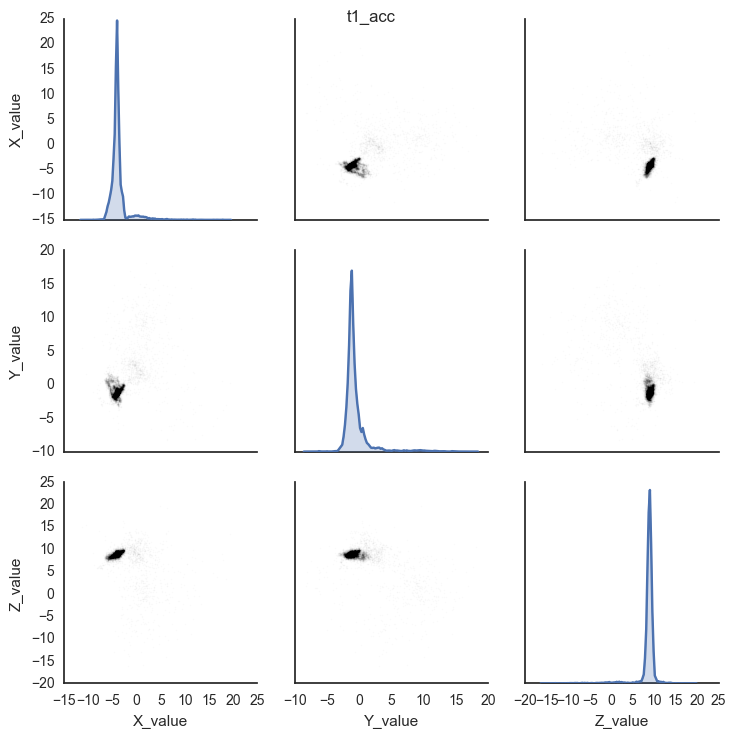

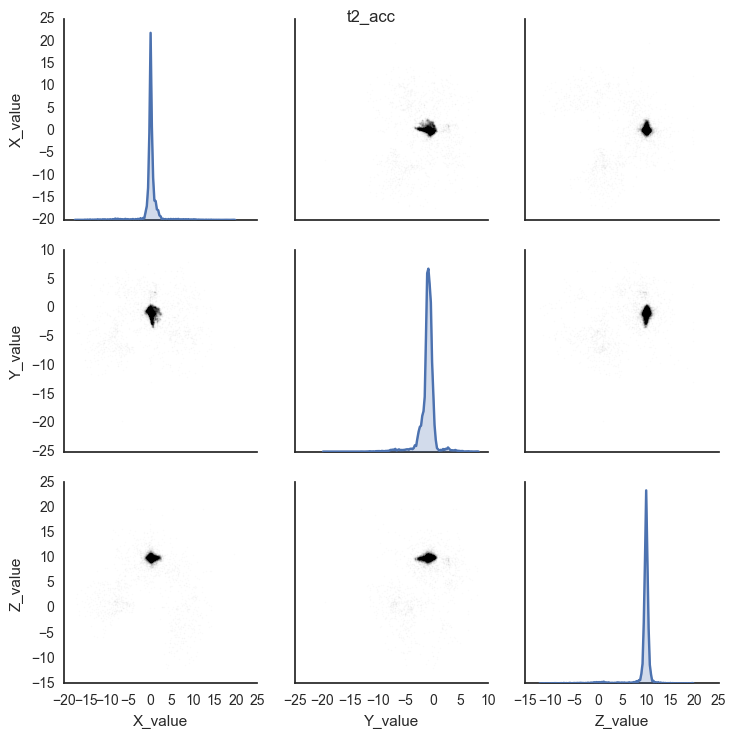

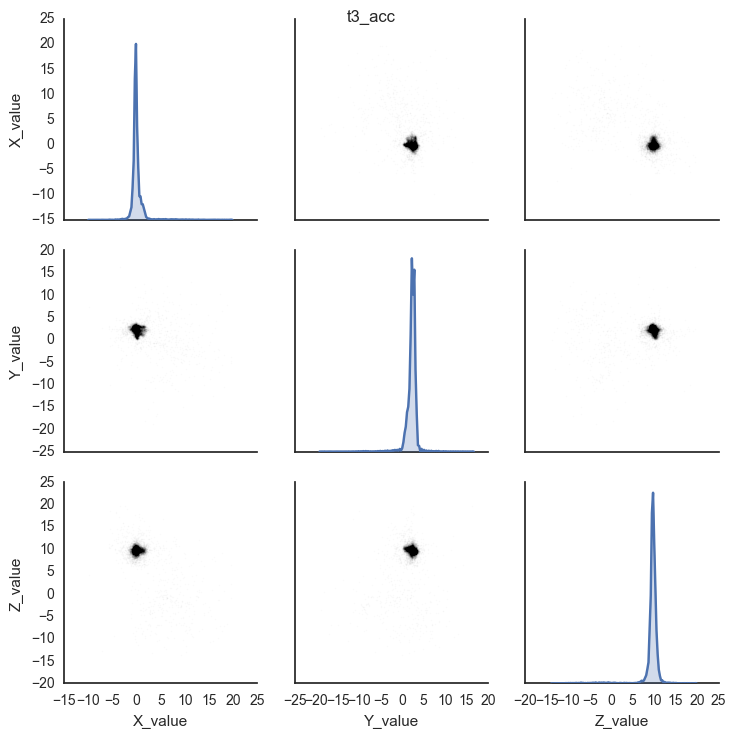

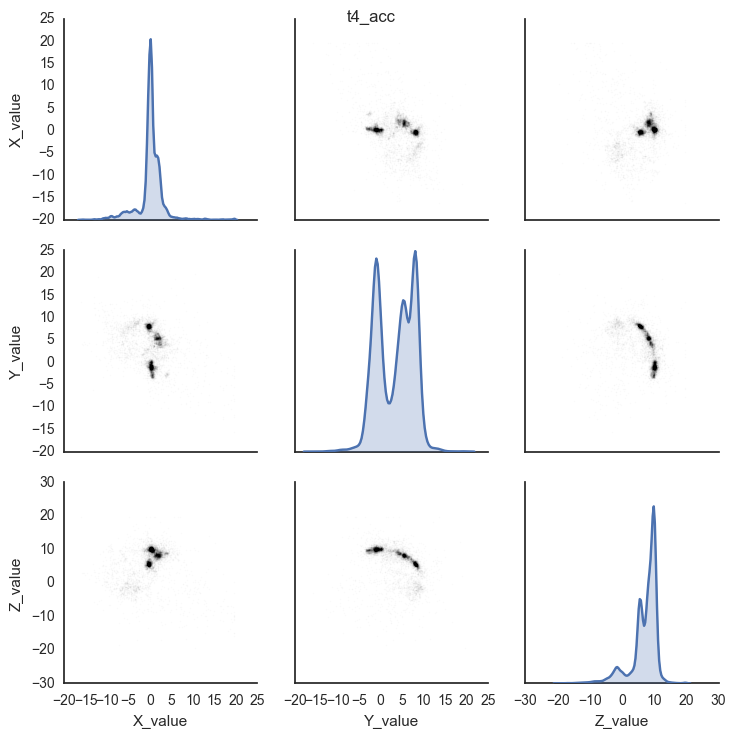

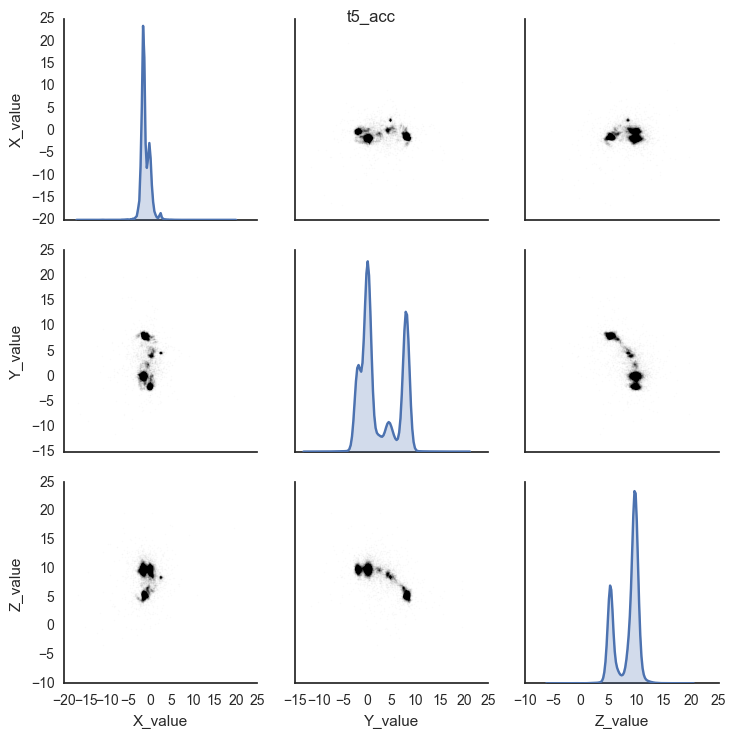

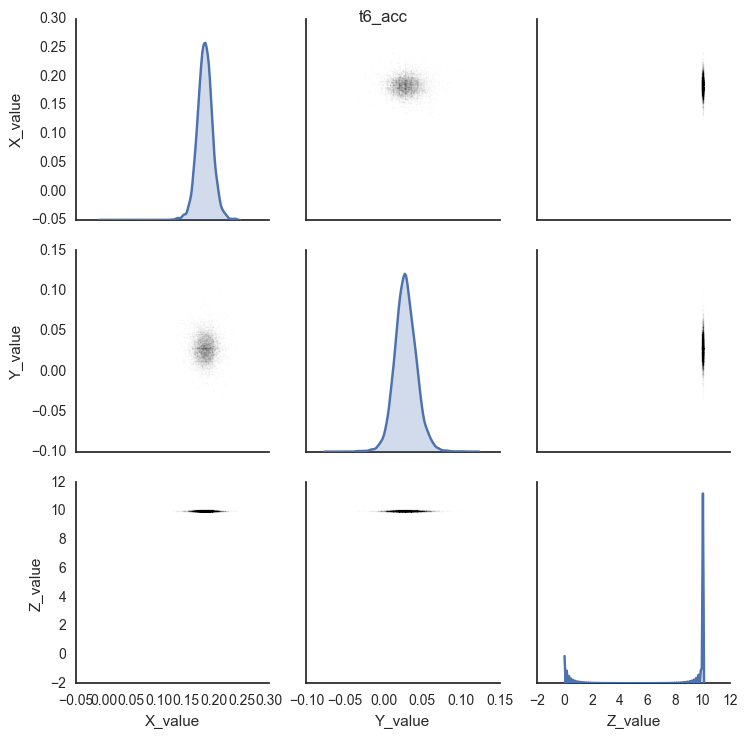

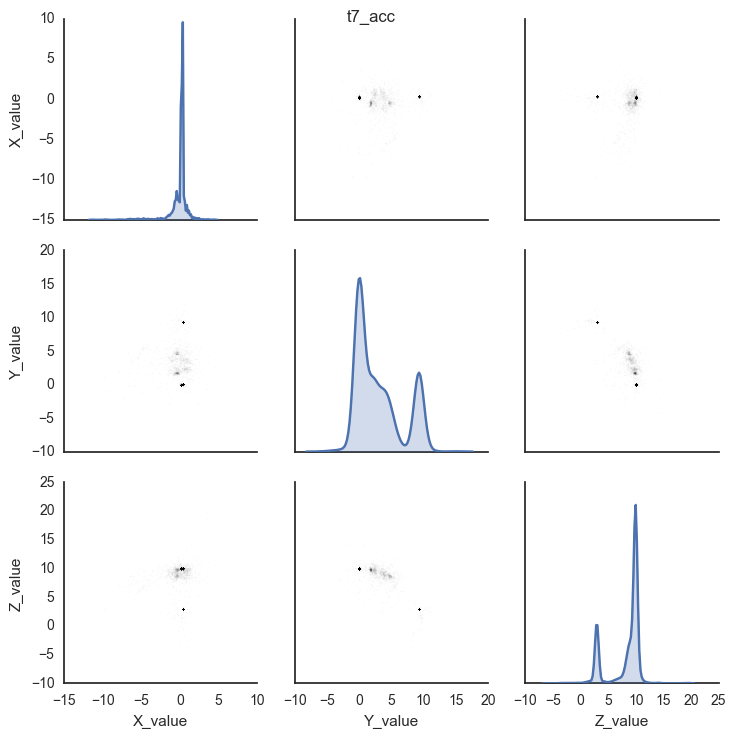

In [13]:
#Pairplot for each trip showing the joint distribution of points for each sensor; KDE of the marginals on diag.
sensor = 0 #0=acc, 1=gyro, 2=mag

with sns.axes_style("white"):
    for i,df in enumerate(data[sensor]):
        sns.pairplot(df, vars = ['X_value','Y_value','Z_value'], diag_kind="kde",
             plot_kws=dict(s=1, facecolor='k', linewidth=0, alpha = 0.02), diag_kws=dict(shade=True))
        plt.suptitle(dkeys[sensor][i])
        plt.show()

##  Applying k-means to visualize the clustering in acceleration space:

We'll do a quick k-means analysis to characterize the clustering.  In this case, the number of clusters is selected by manual examination and a simple silhouette analysis.  After clustering, we visualize the marginal distributions and also create a scatter plot in three dimensions where the points are color coded by cluster ID.  Note that we do not standardize or normalize the data in this case.  The values of each axis of the accelerometer have the same potential range, and the norm of the vector they represent is a physically meaningful value.      

In [14]:
data_c = data.copy()
#data_c[0][1].describe()

__________________________________________________
init    Nclust time    inertia silhouette
k-means++  2   0.38s    85128   0.737
k-means++  3   0.46s    50835   0.706
k-means++  4   0.64s    31241   0.623
k-means++  5   1.23s    28491   0.556
k-means++  6   2.63s    26290   0.409


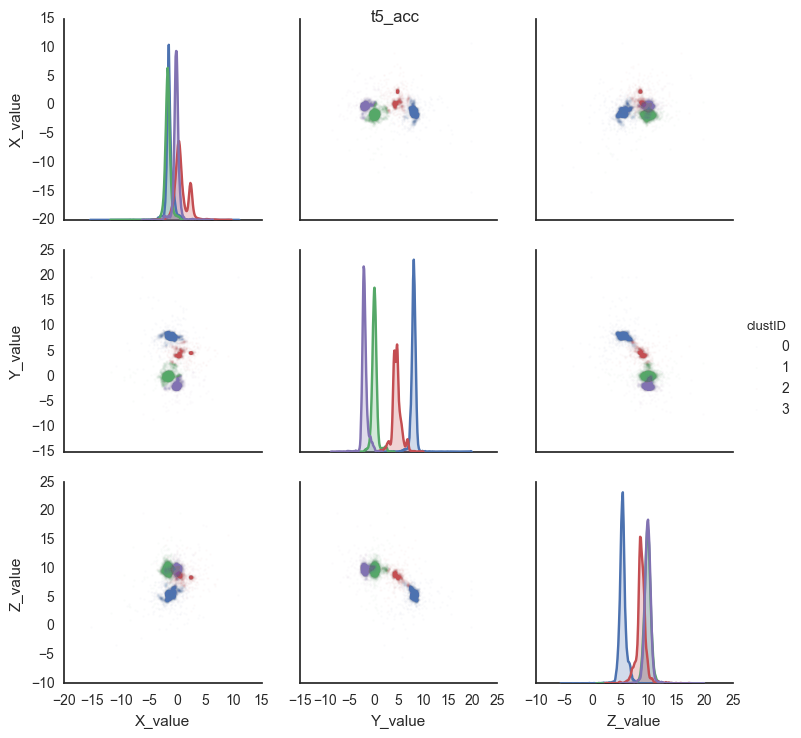

In [15]:
#k-means on trip5, which has multiple stationary points in orientation space
i = 0
j = 5
tb = 10.
te = 800.

kdata = data_c[i][j-1][mask(data_c[i][j-1],tb,te)]
testdata = pd.DataFrame.as_matrix(kdata)

# a bit of cribbing from the scikit-learn documentation for convenience; see function section for scitation
print(50 * '_')
print('% 9s' % 'init' '    Nclust time    inertia silhouette')
    
nclust = [2,3,4,5,6]
#running k-means for different numbers of clusters
for n in nclust:
    km_stats(cluster.KMeans(init='k-means++', n_clusters=n, n_init=100), name='k-means++',
             data=pd.DataFrame.as_matrix(kdata), ss=1000, Nc=n)

#manual examination and silhouette analysis shows that K=3 or 4 is reasonable     
km = cluster.KMeans(init='k-means++', n_clusters=4, n_init=100)
km.fit(pd.DataFrame.as_matrix(kdata))

kdata['clustID'] = km.labels_
clustlist = kdata.clustID.unique()

with sns.axes_style("white"):
    sns.pairplot(kdata, vars = ['X_value','Y_value','Z_value'], hue="clustID",diag_kind="kde",
             plot_kws=dict(s=2, linewidth=0, alpha = 0.03), diag_kws=dict(shade=True))
    plt.suptitle(dkeys[i][j-1])


In [16]:
#number of points in each cluster; 
#the sampling rate is roughly uniform, so this distribution is effectively that same one we'd see 
#if we had resampled and interpolated on the temporal axis
kdata.groupby(['clustID']).size()

clustID
0    7809
1    9582
2    1699
3    4609
dtype: int64

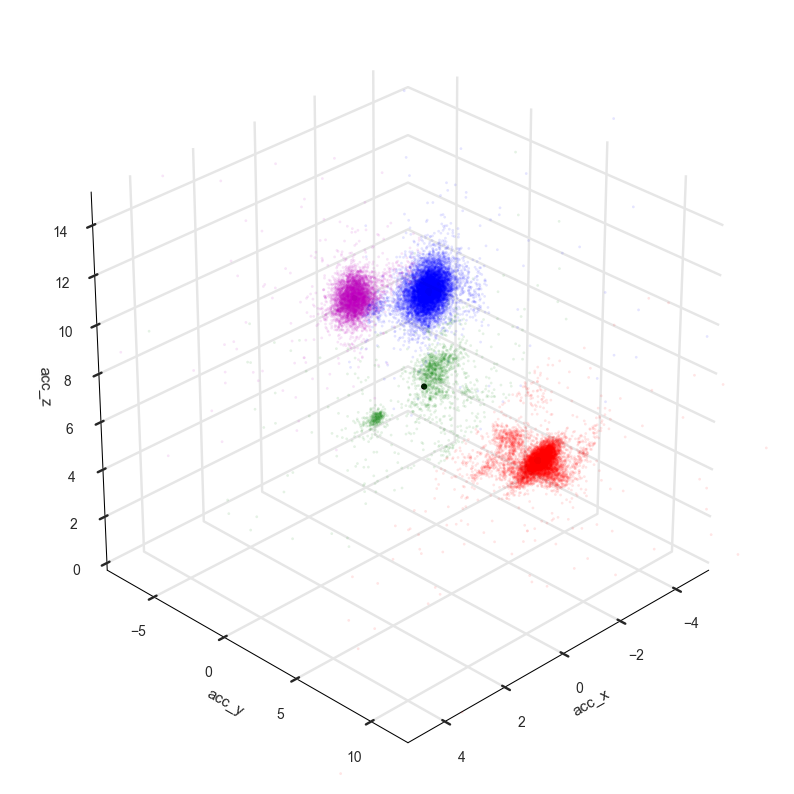

In [17]:
#note: colors for clusters are not necessarily the same as those above
kmcc = km.cluster_centers_

#mapping clusterID to different colors
cc = ('r','b','g','m','y','c')
lst = np.ndarray.tolist(km.labels_)
dct = {0:'r', 1:'b', 2:'g', 3:'m', 4:'y', 5:'c'}
kmcolors = [dct[k] for k in lst]

ax1,fig = figprep(45,30)
ax1.set_xlabel('acc_x'), ax1.set_ylabel('acc_y'), ax1.set_zlabel('acc_z')
ax1.set_xlim3d(-5,5)
ax1.set_ylim3d(-8,12)
ax1.set_zlim3d(0,15)

ax1.scatter(kdata['X_value'],kdata['Y_value'],kdata['Z_value'], c=kmcolors, s=4, alpha = 0.1, linewidth=0)
ax1.scatter(kmcc[:,0],kmcc[:,1],kmcc[:,2], c='k', s=20, zorder=1, linewidth=0)

plt.show()

So we can see the clustering, which is nice, but even with a large # of cluster centroids, the algorithm has difficulty resolving substructure: using 5 or 6 centroids begins to split the main clusters before it picks up minor satellites.  Also, recall that with only accelerometer data, we are unable to distinguish different values of yaw in the inertial frame.  To do this we are going to need to analyze the gyro data.

-----
# Estimating Orientation-Vector Trajectories

In the following section, we compute approximate trajectories for the orientation of the sensor frame relative to the inertial frame.  Ideally, we would develop a probabilistic map of physical locations inside the car where the phone is likely to be; this would be markedly different in the driver-mode and passenger-mode cases.  Analyses of a new trip in this context could provide powerful features for classification.  Unfortunately, the non-inertial reference frame of the car and the relatively low accuracy of MEMS IMU sensors render a full, intra-vehicle positional analysis prohibitive.  

On the other hand, it is possible to make a relatively accurate mapping of the phone in orientation space.  If we assume the mapping between stable positions and orientations is approximately one-to-one, then we can analyze orientation as a proxy for position and create discriminative features.

Computation of the orientation trajectories is carried out using quaternions.  Quaternions arise out of an extension of complex numbers to higher dimensionality (one real and three imaginary) and are a compact and powerful means of specifying arbitrary orientations and rotations.  A given quaternion, $\mathbf{p}=[p_r,\mathbf{p_p}]$, can be expressed as the sum of "real" and "pure" components, $[p_r,0]$ and $[0,\mathbf{p_p}]$.  The three imaginary basis vectors in this representation relate to one another in the manner of cross products

$$\begin{array}{ccc}ij=k&jk=i&ki=j\\ji=-k&kj=-i&ik=-j\end{array}$$

with the additional constraint

$$i^{2}=jj=kk=ijk=-1.$$

In contrast to Euler angles, quaternions do not suffer from gimbal lock; they are an elegant and efficient means by which to encode and apply rotations.  A quaternion rotation is parameterized simply by a rotation angle $\theta$ and an axis $\mathbf{u} = (u_i, u_j, u_k) = u_i\mathbf{i} + u_j\mathbf{j} + u_k\mathbf{k}$ that goes through the origin of the body frame, which is known as an Euler axis.  This rotation, as expressed in quaternion formalism is effectively a higher-dimensional extension of Euler's formula $e^{i\theta}=cos\theta + i\sin\theta$, namely

$$\mathbf{q} = e^{\frac{\theta}{2}{(u_i\mathbf{i} + u_j\mathbf{j} + u_k\mathbf{k})}} = \cos \frac{\theta}{2} + (u_i\mathbf{i} + u_j\mathbf{j} + u_k\mathbf{k}) \sin \frac{\theta}{2}$$

Using the quaternion expressions for products, conjugates, norms and inverses

$$\mathbf{q*p}=[q_{r},\mathbf{q_{p}}][p_{r},\mathbf{p_{p}}]=[q_{r}p_{r}-\mathbf{q_{p}}\cdot\mathbf{p_{p}},\; q_{r}\mathbf{p_{p}}+p_{r}\mathbf{q_{p}}+\mathbf{q_{p}}\times\mathbf{p_{p}}]\\$$

$$\mathbf{q}^{*}=[q_{r},-\mathbf{q_{p}}]\\$$

$$\|\mathbf{q}\|^{2}=\mathbf{q*q}^{*}=[q_{r}^{2}+\|\mathbf{q_{p}}\|^{2}, 0]\\$$

$$\mathbf{q}^{-1}=\frac{\mathbf{q}^{*}}{\|\mathbf{q}\|^{2}}$$

we can describe the transformation of a pure quaternion, $\mathbf{p}$, by a quaternion rotation, $\mathbf{q}$, as

$$ \mathbf{p}'= \mathbf{q*p*q}^{-1}.$$

In this expression, $\mathbf{q}$ and $\mathbf{q}^{-1}$ each provide half of the desired rotation.  Applying the roation as a conjugate pair ensures that the result will be a pure quaternion with the same length as the original.

In our case, we describe the orientation of the sensor frame with respect to the inertial frame as a quaternion, $\mathbf{Q}$, which is evolved in time using the 3-axis, angular-velocity data froma the rate gyro.  We initalize the value of $\mathbf{Q}$ with the identity quaternion, $[1,(0,0,0)]$.  The angular velocity is reported in the sensor frame, in $\mathrm{rad/s}$ as $\mathbf{\omega} = (\omega_i, \omega_j, \omega_k) = \omega_i\mathbf{i} + \omega_j\mathbf{j} + \omega_k\mathbf{k}$.  The direction of this vector specifies the axis of rotation and it's magnitude is the instantaneous rate of rotation about that axis.  The quaternion representing each timestep is given by

$$\mathbf{q}^{(t)} = \Big[\cos \frac{\|\omega^{(t)}\|dt^{(t)}}{2}, \sin \frac{\|\omega^{(t)}\|dt^{(t)}}{2} \hat{\omega}^{(t)}\Big]$$

and we evolve the orientation quaternion as

$$\mathbf{Q}^{(t+dt)} = \mathbf{Q}^{(t)}* q^{(t)}.$$

Finally, transformations of vectors between the sensor-frame ($\mathbf{S}$) and the inertial frame ($\mathbf{I}$) are accomplished by

$$ \mathbf{a_{I}}= \mathbf{Q*a_{S}*Q}^{-1}$$

and

$$ \mathbf{a_{S}}= \mathbf{Q^{-1}*a_{I}*Q}$$

respectively.

-----

## Quaternion-Rotation Example
As a simple demonstration, the function `rand_rot_walk` generates synthetic, 3-axis rate-gyrometer data consting of a drift vector and isotropic gaussian noise.  It then computes the corresponding rotation of the orientation for each timestep using the process described above.  The progressive transformation of a vector pointing along the inertial y-axis is shown below. 

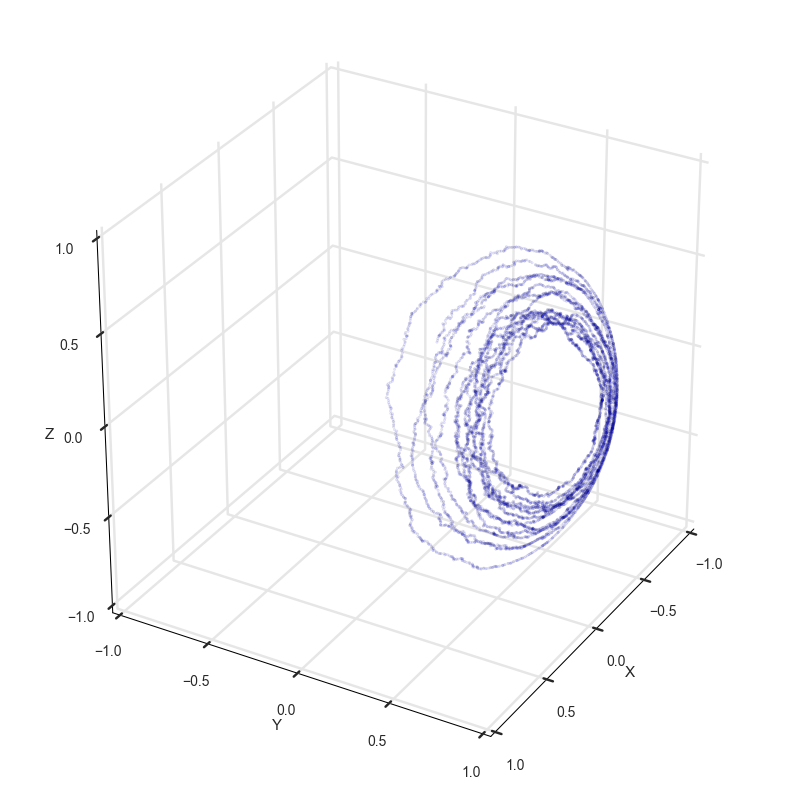

In [18]:
Walk = rand_rot_walk([0,1,0],[0.1,0.4,0.1],0.2,10000,0.02, reverse=False)

ax,fig = figprep(30,30)
ax.scatter3D(Walk[:, 0], Walk[:, 1], Walk[:, 2], c='b', s=3, alpha=0.1)
plt.show()

-----
# Fingerprinting rotation space

In order to make the gyro data useful for computing orientations, we need to deal with the low-frequency drift errors that are common for MEMS rate gyros.  For IMUs this is typically done by a sensor fusion technique that combines the accelerometer and gyro data; typical methods include Kalman and complementary filtering.  As a simple ad-hoc proof of principle, we'll ignore the correction of tilt error using the accelerometer data and instead apply a simple high-pass filter to the gyro data.  This has two nice effects: it filters out the systematic low-frequency drift, and it also removes most spectral content related to macro-scale motions of the vehicle (e.g. turning, acceleration/braking, slow changes in terrain, etc...).  This gives us an pretty good approximation of the main signal of interest, which is HI followed by placement in a high-probability location/orientation.  We should now be able to visualize these stationary points in rotation space.

In the section below, we compute the trajectory of the phone's orientation through rotation space for filtered and unfiltered gyro data.  The first plot shown below is for a controlled test in which the phone was left stationary and undisturbed on a table for ~3.5 min.  The positive $\hat{z}$ direction is roughly normal to the table surface, and so we take $\mathbf{v} = (v_x, v_y, v_z) = \hat{z}\:$ as the initial orientation in the inertial frame.

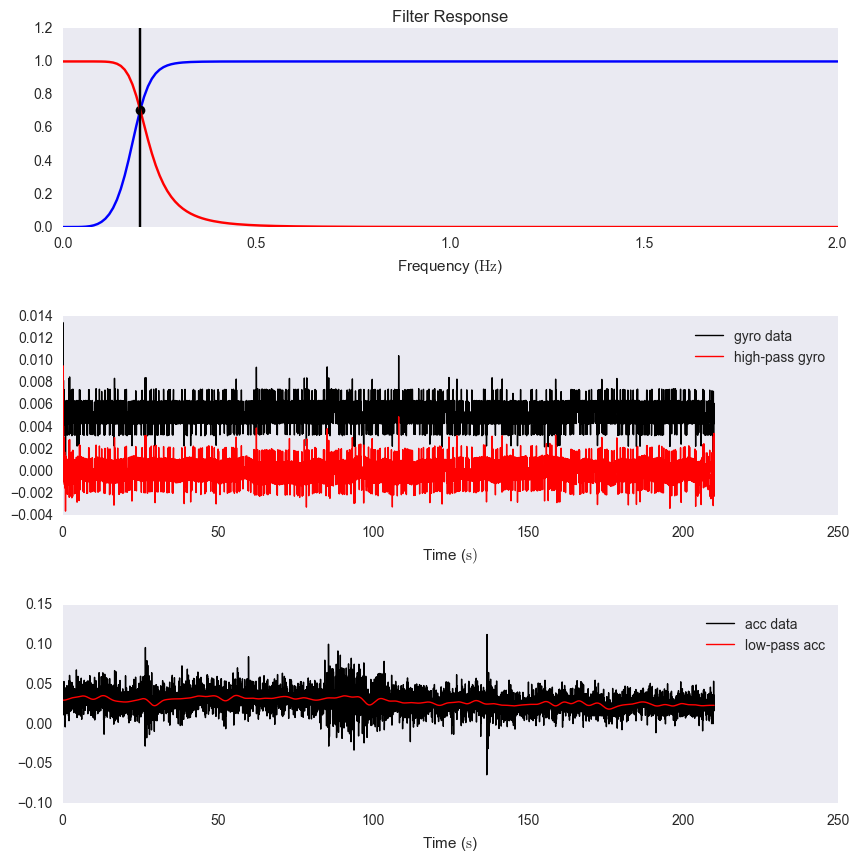

In [19]:
#i = 0
j = 6
tb = 0.
te = 300.
tbase_i = 1
tbase_r = 5
order = 5
fsamp = 1/0.005
fcut = 0.2

#example filtering of gyro and accelerometer data
yfilt_g, tvec_g, data_num_g, dtvec_g  = filter_data(data_c[1][j-1], tb, te, tbase_i, tbase_r, order, fcut, 'high')
yfilt_a, tvec_a, data_num_a, dtvec_a  = filter_data(data_c[0][j-1], tb, te, tbase_i, tbase_r, order, fcut, 'low')

##Visualizing filters and filtered signals
#implementation from:
#http://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
b, a = butter_dig(fcut, fsamp, 'high', order)
w, h = signal.freqz(b, a, worN=10000)
b2, a2 = butter_dig(fcut, fsamp, 'low', order)
w2, h2 = signal.freqz(b2, a2, worN=10000)

plt.subplot(3, 1, 1)
plt.plot(0.5*fsamp*w/np.pi, np.abs(h), 'b')
plt.plot(fcut, 0.5*np.sqrt(2), 'ko')
plt.plot(0.5*fsamp*w2/np.pi, np.abs(h2), 'r')
plt.axvline(fcut, color='k')
plt.xlim(0, 2)
plt.title("Filter Response")
plt.xlabel('Frequency ($\mathrm{Hz}$)')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(tvec_g, data_num_g[:,0], 'k-', linewidth=1, label='gyro data')
plt.plot(tvec_g, yfilt_g[:,0], 'r-', linewidth=1, label='high-pass gyro')
plt.xlabel('Time ($\mathrm{s})$')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tvec_a, data_num_a[:,1], 'k-', linewidth=1, label='acc data')
plt.plot(tvec_a, yfilt_a[:,1], 'r-', linewidth=1, label='low-pass acc')
plt.xlabel('Time ($\mathrm{s}$)')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.45)
plt.show()

In [20]:
#average norm of the filtered acceleration vector
np.mean(np.linalg.norm(yfilt_a, axis=1))

10.006367402243285

In the figure below, the axes have the same color convention as the Android-API coordinate system shown in the introduction.  The gray tracks show the integration of the raw gyro signal (no filtering).  Integration of the high-pass gyro signal results in the color coded points, effectively at their original positions.  The dot size has been made large for clarity and is not indicative of noise.  Close examination will reveal a yellow dot at approximately the tip of the z-axis.  This is the low-pass accelerometer after normalization.  If sensor fusion was included to correct for tilt error then the red dot would quickly come into alignment with the yellow dot.

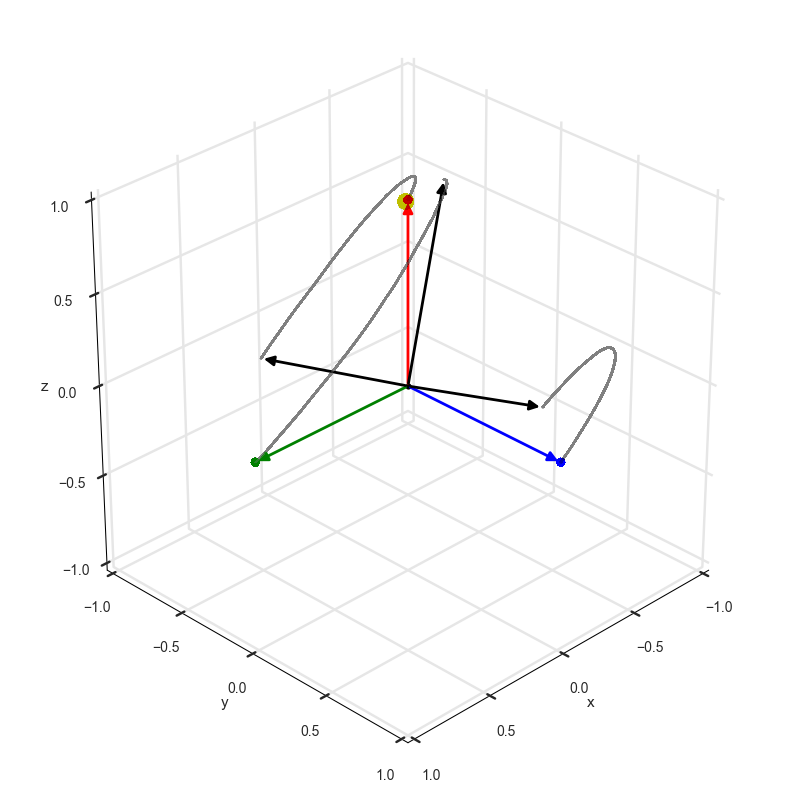

In [21]:
#initial unit vectors for coordinate axes
ivectors = [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])]

gyroWalk = [gyro_walk_c(x, data_num_g, data_num_a, dtvec_g, filt=False) for x in ivectors]

#unfiltered gyro and endpoints
#gyroWalk = [gyro_walk(x, data_num_g, dtvec_g, reverse=False) for x in ivectors]
endvecs = [np.squeeze(gyroWalk[0][0][-1:,:]), np.squeeze(gyroWalk[1][0][-1:,:]), np.squeeze(gyroWalk[2][0][-1:,:])]


#filtered gyro
#gyroWalk_filt = [gyro_walk(x, yfilt_g, dtvec_g) for x in ivectors]
gyroWalk_filt = [gyro_walk_c(x, yfilt_g, yfilt_a, dtvec_g, filt=False) for x in ivectors]


#figure setup and labelling
ax1,fig = figprep(45,30)
ax1.set_xlabel('x'), ax1.set_ylabel('y'), ax1.set_zlabel('z')

colors=['g', 'b', 'r']
ax1.scatter(0, 0, 0, c='k', s=20, alpha = 1, linewidth=0)
[ax1.scatter(x[0][:,0], x[0][:,1], x[0][:,2], c='gray', s=4, alpha=0.01, linewidth=0) for x in gyroWalk]
[ax1.scatter(x[0][:,0], x[0][:,1], x[0][:,2], c=colors[idx], s=40, alpha=0.01, linewidth=0) for idx,x in enumerate(gyroWalk_filt)]

#draw initial and final orientations for coordinate axes
draw_axes(ax1, ivectors, 20)
draw_axes(ax1, endvecs, 20, allblack=True)

#normalizing filtered accelerometer data for overlay with gyro
ymag = np.linalg.norm(yfilt_a,axis=1)
yfilt_anorm = yfilt_a/ymag[:,None]
#initgrav = np.mean(yfilt_anorm[1:10,:], axis=0)
ax1.scatter(yfilt_anorm[:, 0], yfilt_anorm[:, 1], yfilt_anorm[:, 2], c='y', s=150, alpha = .004, linewidth=0)

plt.show()

-----

# Stationary points for a trip

We will now apply the same procedure to the data for trip #5, which is most representative of my typical driving behavior.  Based on my driving and cellphone-use habits, we expect to see four or five distinct sensor orientations in rotation space.  The distribution of these points could be "featurized" in a variety of ways (e.g. number, relative separation, pairwise-transition probabilities, dwell time, temporal coherence of given transitions with vehicle speed).  The signature for a given trip could then be analyzed in the context of that particular driver's trip history, the trip history for all other drivers, or both.  An important caveat is that this analysis can not distinguish between instances where the phone is in a different location but the same orientation.  Unfortunately, it is probably not possible to compute the phone's physical location to sub-meter accuracy inside an emphatically non-inertial reference frame using only a low-cost IMU (again, that was my original hope).

The the precise distribution of stationary points depends somewhat on the cutoff frequency of the filter.  Is is primarily due to the spectral overlap between the different sources of motion (HI, vehicle).

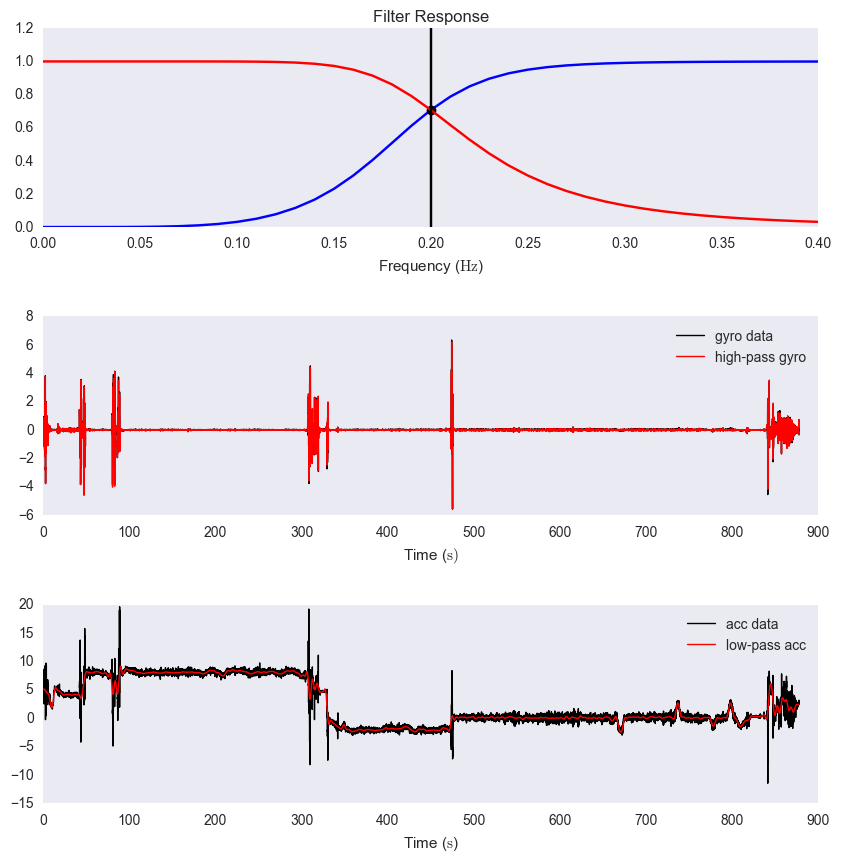

In [22]:
#i = 0
j = 5
tb = 0.
te = 900.
tbase_i = 1
tbase_r = 5
order = 5
fsamp = 1/0.005
fcut = 0.2

#filtering of gyro data
yfilt_g, tvec_g, data_num_g, dtvec_g  = filter_data(data_c[1][j-1], tb, te, tbase_i, tbase_r, order, fcut, 'high')
#filtering of accelerometer data
yfilt_a, tvec_a, data_num_a, dtvec_a  = filter_data(data_c[0][j-1], tb, te, tbase_i, tbase_r, order, fcut, 'low')

##Visualizing filters and filtered signals
#implementation from:
#http://stackoverflow.com/questions/25191620/creating-lowpass-filter-in-scipy-understanding-methods-and-units
b, a = butter_dig(fcut, fsamp, 'high', order)
b2, a2 = butter_dig(fcut, fsamp, 'low', order)

w, h = signal.freqz(b, a, worN=10000)
w2, h2 = signal.freqz(b2, a2, worN=10000)

plt.subplot(3, 1, 1)
plt.plot(0.5*fsamp*w/np.pi, np.abs(h), 'b')
plt.plot(fcut, 0.5*np.sqrt(2), 'ko')
plt.plot(0.5*fsamp*w2/np.pi, np.abs(h2), 'r')
plt.axvline(fcut, color='k')
plt.xlim(0, 2*fcut)
plt.title("Filter Response")
plt.xlabel('Frequency ($\mathrm{Hz}$)')
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(tvec_g, data_num_g[:,0], 'k-', linewidth=1, label='gyro data')
plt.plot(tvec_g, yfilt_g[:,0], 'r-', linewidth=1, label='high-pass gyro')
plt.xlabel('Time ($\mathrm{s})$')
plt.grid()
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(tvec_a, data_num_a[:,1], 'k-', linewidth=1, label='acc data')
plt.plot(tvec_a, yfilt_a[:,1], 'r-', linewidth=1, label='low-pass acc')
plt.xlabel('Time ($\mathrm{s}$)')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.45)
plt.show()

In [23]:
#average norm of the filtered acceleration vector
np.mean(np.linalg.norm(yfilt_a, axis=1))

9.9527708793395337

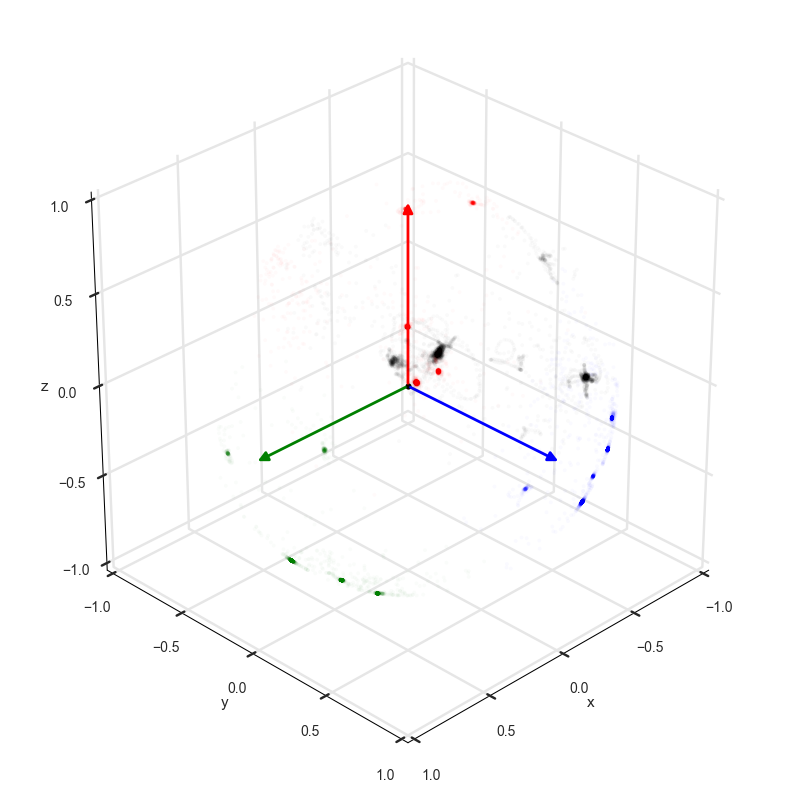

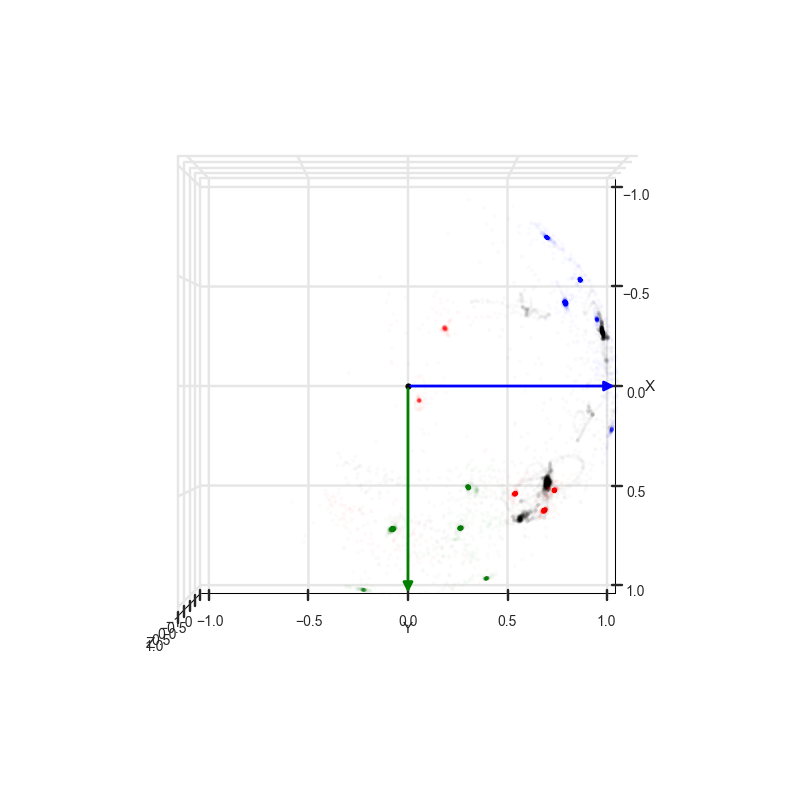

In [24]:
ivectors = [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])]
Nth = 50

#filtered gyro
gyroWalk_filt = [gyro_walk_c(x, yfilt_g, yfilt_a, dtvec_g, filt=False) for x in ivectors]

acc = np.lib.pad(yfilt_a,((0,0),(1,0)), 'constant', constant_values = 0)
acc_quat = quaternion.as_quat_array(acc)
Nt = np.shape(gyroWalk_filt[0][1])[0]
acc_inertial_norm = np.empty([Nt,3])

#converting acceleration data to inertial coordinates and normalizing for display
for i,q in enumerate(gyroWalk_filt[0][1][:-1]):
    acc_quat_inertial = q*acc_quat[i]*np.conjugate(q) #convert acc to inertial coords
    v = quaternion.as_float_array(acc_quat_inertial)[0,1:]
    acc_inertial_norm[i] = v/np.linalg.norm(v)


colors=['g', 'b', 'r']
ax1,fig = figprep(45,30)
ax1.set_xlabel('x'), ax1.set_ylabel('y'), ax1.set_zlabel('z')

ax1.scatter(0, 0, 0, c='k', s=20, alpha = 1, linewidth=0)
[ax1.scatter(x[0][0::Nth,0], x[0][0::Nth,1], x[0][0::Nth,2], c=colors[idx], s=8, alpha=0.02, linewidth=0) for idx,x in enumerate(gyroWalk_filt)]
ax1.scatter(acc_inertial_norm[0::Nth,0], acc_inertial_norm[0::Nth,1], acc_inertial_norm[0::Nth,2], c='k', s=8, alpha=0.02, linewidth=0)

draw_axes(ax1, ivectors, 20, allblack=False)
plt.show()

ax1,fig = figprep(0,90)
ax1.scatter(0, 0, 0, c='k', s=20, alpha = 1, linewidth=0)
[ax1.scatter(x[0][0::Nth,0], x[0][0::Nth,1], x[0][0::Nth,2], c=colors[idx], s=8, alpha=0.02, linewidth=0) for idx,x in enumerate(gyroWalk_filt)]
ax1.scatter(acc_inertial_norm[0::Nth,0], acc_inertial_norm[0::Nth,1], acc_inertial_norm[0::Nth,2], c='k', s=8, alpha=0.02, linewidth=0)

draw_axes(ax1, ivectors, 20, allblack=False)
plt.show()

Nice.  We have some high-probability, stationary points for the orientation of the sensor frame; but, there's a problem.  The black points in the figure above correspond to the accelerometer measurement in inertial coordinates.  Most of the time, this should be measuring something that's relatively close to gravity, but in the plot above, there is no discernable signal at $(0,0,1)$.  As a result, both the absolute and relative locations of these stationary points are erroneous.  We fix this using sensor fusion in the section below.

Note that the clusters of black points here correspond to the clustering that we examined earlier with k-means, except here we've filtered out the high-frequency component of the measurement, and our absolute mapping to the inertial frame depends entirely on the orientation our phone happened to have during our first datapoint.

-----
# Sensor fusion: complementary filtering

As we apply incremental rotations to the sensor frame's orientation quaternion, we can always recover which way corresponds to "up" by converting the pure quaternion $\mathbf{z} = [0,\mathbf{\hat{z}}]=[0,(0,0,1)]$ to sensor frame coordinates.  One major issue with using low-cost MEMS IMUs is that, as we integrate the gyro data, our estimate of "up" will drift away from the true value; this divergence is known as tilt error.  Luckily, we can fuse the gyro measurements with those from the accelerometer to mitigate tilt error.  

The accelerometer is measuring a linear combination of gravity (specifically the normal force in response to gravity) and dynamic forces due to linear and rotational accelerations of the vehicle.  We wouldn't want to correct our sense of up while the accelerometer data contains a spurious, non-gravitational signal; therefore, we wait for the magnitude of the accelerometer vector to be within a certain tolerance, $\epsilon_{grav}$, of $9.81 m/s^{2}$, and for the raw gyroscope signal to be below a certain threshold, $\epsilon_{gyro}$; note that a static measurement of gravity with these sensors can have an offset error on the order of a percent, as seen above.  If these conditions are met then use a dot product to compute the angular error, $\phi_e$ between our accelerometer measurement and the inertial z-axis.  We then compute $\hat{u}$, the axis of rotation required for tilt correction, by taking the cross product of our normalized measurement vector with the z-axis.  The corresponding corrective rotation quaternion can then be applied to $\mathbf{Q}$ as 

$$\mathbf{Q}_c = q(\phi_e, \mathbf{\hat{u}})*\mathbf{Q}.$$  

I've implemented this complementary filter in the function `gyro_walk_c`.  The parameter `alpha` controls how much of the detected tilt error is removed in a single timestep, provided that our previously mentioned filter conditions on the accelerometer and gyro readings are satisfied.  The tilt error removed in a given iteration is $\phi_c = (1-\alpha)\phi_e$.

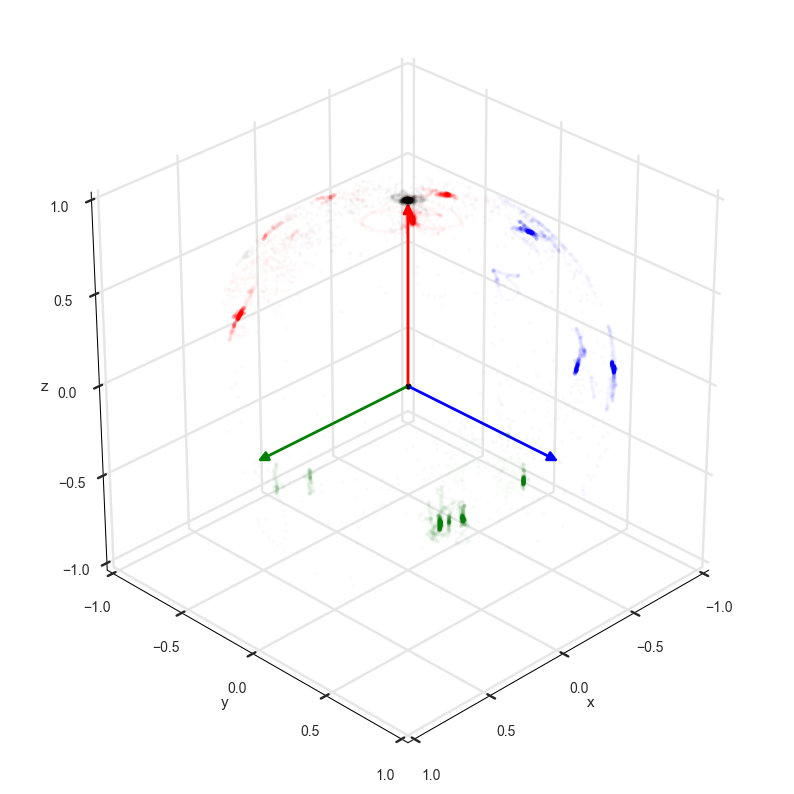

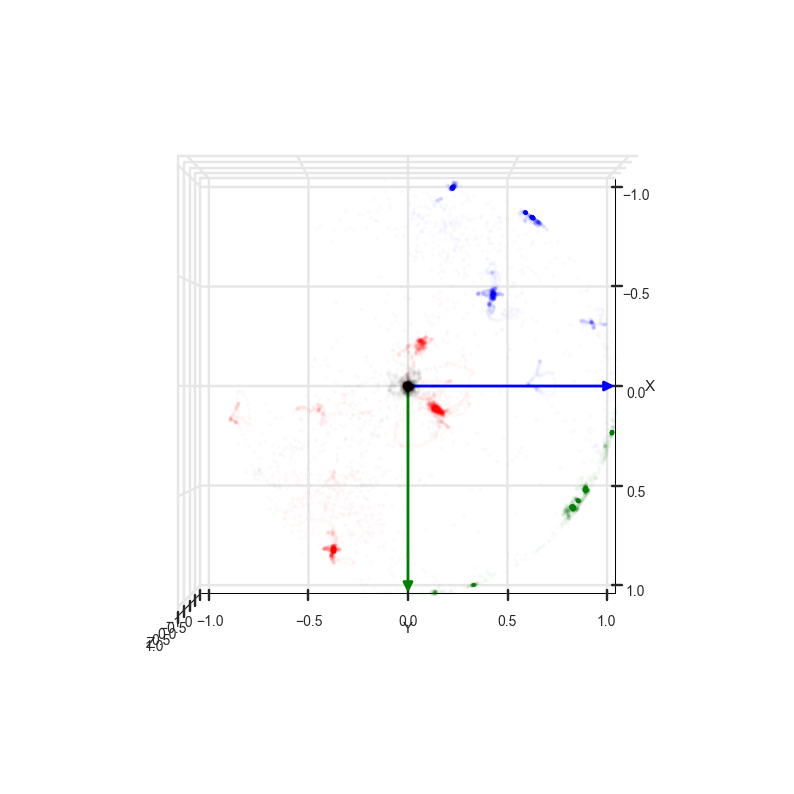

In [25]:
ivectors = [np.array([1,0,0]), np.array([0,1,0]), np.array([0,0,1])]
Nth = 50

#gyro walk with filtered data and sensor fusion
gyroWalk_filt = [gyro_walk_c(x, yfilt_g, yfilt_a, dtvec_g, eps_grav = 0.1, eps_gyro = 0.1, alpha=0.995, g=9.95) for x in ivectors]

acc = np.lib.pad(yfilt_a,((0,0),(1,0)), 'constant', constant_values = 0)
acc_quat = quaternion.as_quat_array(acc)
Nt = np.shape(gyroWalk_filt[0][1])[0]
acc_inertial_norm = np.empty([Nt,3])

#converting acceleration data to inertial coordinates and normalizing for display
for i,q in enumerate(gyroWalk_filt[0][1][:-1]):
    acc_quat_inertial = q*acc_quat[i]*np.conjugate(q) #convert acc to inertial coords
    v = quaternion.as_float_array(acc_quat_inertial)[0,1:]
    acc_inertial_norm[i] = v/np.linalg.norm(v)

    
colors=['g', 'b', 'r']
ax1,fig = figprep(45,30)
ax1.set_xlabel('x'), ax1.set_ylabel('y'), ax1.set_zlabel('z')

ax1.scatter(0, 0, 0, c='k', s=20, alpha = 1, linewidth=0)
[ax1.scatter(x[0][0::Nth,0], x[0][0::Nth,1], x[0][0::Nth,2], c=colors[idx], s=8, alpha=0.02, linewidth=0) for idx,x in enumerate(gyroWalk_filt)]
ax1.scatter(acc_inertial_norm[0::Nth,0], acc_inertial_norm[0::Nth,1], acc_inertial_norm[0::Nth,2], c='k', s=8, alpha=0.02, linewidth=0)

draw_axes(ax1, ivectors, 20, allblack=False)
plt.show()

ax1,fig = figprep(0,90)
ax1.scatter(0, 0, 0, c='k', s=20, alpha = 1, linewidth=0)
[ax1.scatter(x[0][0::Nth,0], x[0][0::Nth,1], x[0][0::Nth,2], c=colors[idx], s=8, alpha=0.02, linewidth=0) for idx,x in enumerate(gyroWalk_filt)]
ax1.scatter(acc_inertial_norm[0::Nth,0], acc_inertial_norm[0::Nth,1], acc_inertial_norm[0::Nth,2], c='k', s=8, alpha=0.02, linewidth=0)

draw_axes(ax1, ivectors, 20, allblack=False)

plt.show()

The clustering of the accelerometer measurements about the z-axis indicates that the complementary filter is successfully correcting the tilt error.  Remember that there should be plenty of legitimate off-axis points due to accelerations from the vehicle and hand interations.  Our active toggling of the complementary filter largely prevents correction of such points.  Obviously, the final results have some sensitivity to the specific thresholds/tolerances and `alpha`.  The values used here have been chosen based on the noise properties of the IMU signals and so that the tilt error will be fully corrected over the course of a few seconds of stability.

To featurize this data, we will need to perform a clustering analysis of the distribution in rotation space.  We will need to compare each data point against proposed cluster centroids, on the unit sphere, using a cosine-similarity metric.  Once we have updated our cluster assignments for every point, we can compute the new centroid location by taking a vector sum of every vector in that cluster and then renormalizing.  This process will be repeated until the algorithm has converged and the cluster assignments are unchanged from the previous iteration.  A standard k-means clustering with Euclidean distance is not suitable for points distributed on a sphere.

For completeness, below is a quick visualization of the filtered acceleration vector as measured in the sensor frame for this trip.

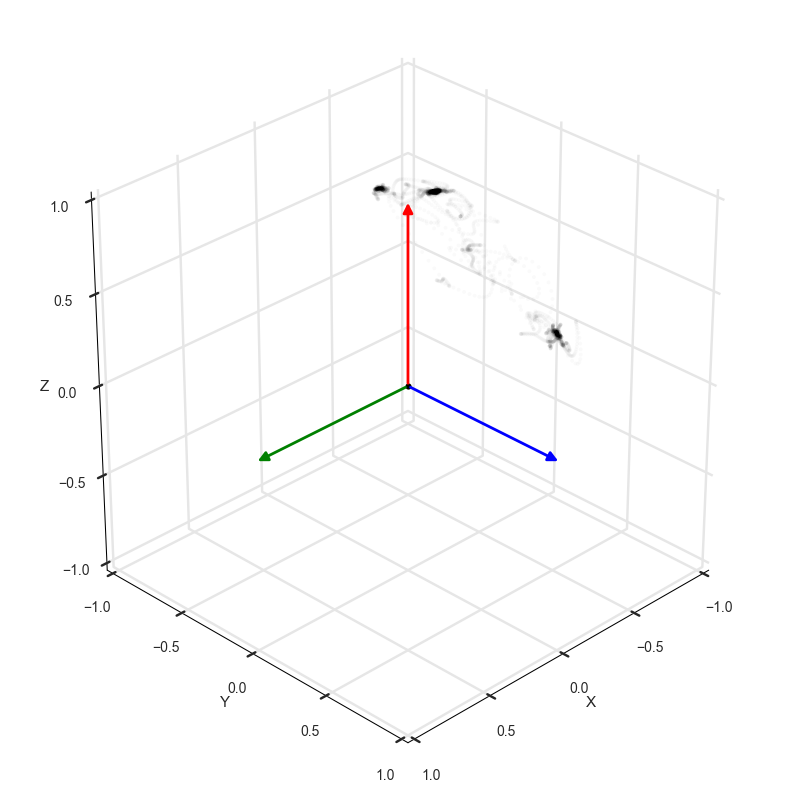

In [26]:
#visualizing filtered accelerometer data in the sensor frame
ymag = np.linalg.norm(yfilt_a,axis=1)
yfilt_anorm = yfilt_a/ymag[:,None]
initgrav = np.mean(yfilt_anorm[1:10,:], axis=0)

Nth = 50
ax1,fig = figprep(45,30)
ax1.scatter(yfilt_anorm[0::Nth, 0], yfilt_anorm[0::Nth, 1], yfilt_anorm[0::Nth, 2], c='k', s=8, alpha = .02, linewidth=0)
ax1.scatter(0, 0, 0, c='k', s=20, alpha = 1, linewidth=0)

draw_axes(ax1, ivectors, 20)

plt.show()

-----
# Simple examples of methods for trip detection

In the figures below we show example spectrograms of the measured acceleration during some of our trips.  The spectrogram is a sliding fast fourier transform (FFT) that allows us to easily visualize frequency content as a function of time.  Analyzing the norm of the accelerometer data, rather than a single axis is helpful because it makes the results and conclusions insensitive to the orientation of the phone.  In the figures below we show spectrograms for two of the trips.  As expected, we detect a distinct spectral signature for walking, in a band between ~1 and 4 Hz, at the beginning and end of each trip.  Note that HI events, which are generally aperiodic, have significantly lower spectral-power density in the region of interest.  When combined with speed data from GPS, we can generate relatively high-fidelity signatures for the beginning and end of each trip.

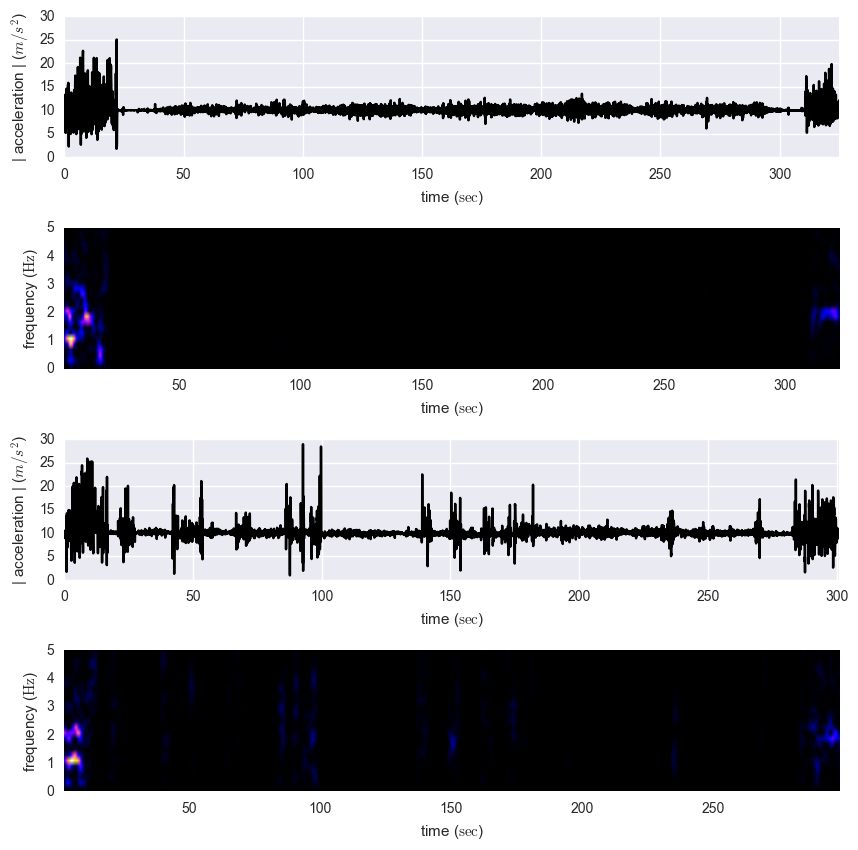

In [27]:
#ugly code; very fast, just for demonstration

i = 0
tb = 0.
te = 400.
fsamp = 1/0.005
winsize = 1024

yfilt_a1, tvec_a1, data_num_a1, dtvec_a1,  = filter_data(data_c[i][2], tb, te, tbase_i, tbase_r, order, 0.2, 'low')
normdata1 = np.linalg.norm(data_num_a1, axis=1)

yfilt_a2, tvec_a2, data_num_a2, dtvec_a2,  = filter_data(data_c[i][3], tb, te, tbase_i, tbase_r, order, 0.2, 'low')
normdata2 = np.linalg.norm(data_num_a2, axis=1)

#plotting time series of the norm acceleration for trip 3
ax1 = plt.subplot(411)
plt.plot(tvec_a1,normdata1, color='k') 
plt.xlim([np.min(tvec_a1),np.max(tvec_a1)])
plt.ylabel('| acceleration | ($m/s^{2}$)')
plt.xlabel('time ($\mathrm{sec}$)')

#creating spectrogram of trip 3
plt.subplot(412)
Pxx, freqs, bins, im = plt.specgram(normdata1, NFFT=winsize, Fs=fsamp, scale='linear', 
                                   detrend='mean' ,noverlap=int(winsize*0.9), cmap='gnuplot2')
plt.grid(None)
plt.gca().axes.set_ylim(np.min(freqs), 5)
plt.gca().axes.set_xlim(np.min(bins), np.max(bins))
plt.ylabel('frequency ($\mathrm{Hz}$)')
plt.xlabel('time ($\mathrm{sec}$)')

#plotting time series of the norm acceleration for trip 4
ax1 = plt.subplot(413)
plt.plot(tvec_a2,normdata2, color='k')
plt.xlim([np.min(tvec_a2),np.max(tvec_a2)])
plt.ylabel('| acceleration | ($m/s^{2}$)')
plt.xlabel('time ($\mathrm{sec}$)')

#creating spectrogram of trip 4
plt.subplot(414)
Pxx2, freqs2, bins2, im2 = plt.specgram(normdata2, NFFT=winsize, Fs=fsamp, scale='linear', 
                                   detrend='mean' ,noverlap=int(winsize*0.9), cmap='gnuplot2')
plt.grid(None)
plt.gca().axes.set_ylim(np.min(freqs2), 5)
plt.gca().axes.set_xlim(np.min(bins2), np.max(bins2))
plt.ylabel('frequency ($\mathrm{Hz}$)')
plt.xlabel('time ($\mathrm{sec}$)')


plt.subplots_adjust(hspace=0.5)
plt.show()

In [28]:
#extra little bit if we want to integrate the spectral density out to a given frequency and visualize over time
#specsum = np.sum(Pxx[freqs<5], axis=0)
#specsum2 = np.sum(Pxx2[freqs2<5], axis=0)
#plt.plot(bins, specsum)
#plt.ylim([0,1])

-----
# Future work

To extend this work, I'm developing methods to featurize the stationary-point distributions that we've computed.  For example, I'm writing a special clustering algorithm that will operate in normalized rotation space and compute accurate centroid locations on the unit sphere.  A standard algorithm like k-means would give erroneous results.  Clustering analysis of the rotation space distributions is important because we'll want to characterize the stationary points based on their relative locations to one another.  We'll then need to formulate similarity metrics, which are insensitive to absolute orientation, so that we can say how coherent different distributions are with one another, i.e. is the map of clusters for this trip more similar to known probabilistic distributions for driver-mode trips or passenger-mode trips?

I might also look at doing a very selective yaw correction when the magnetometer is particularly well behaved, but the utility of this is less obvious.  We aren't particularly interested in knowing the absolute orientation of the phone in the earth frame, since this also contains information about the orientation of the vehicle itself.  Rather, we are most interested in the phone's orientation with respect to the vehicle frame.  For now, our solution of filtering out most of the very low-frequency, inertial-frame yaw rotations via a high-pass filter is probably the best solution.  If we were to add yaw correction, it would effectively undo that filtering; not helpful.

I'll also develop some simple detectors for hand-interaction events; initial versions could easily pick them out by looking at the variance, or even a simple thresholding, of the gyro.  Also, If I can pull the GPS data down from my phone then I'll look at developing an actual trip detector.  

Finally, I'm beginning to look into the use of RNNs with LSTM for processing IMU data streams and detecting important events, e.g. turns, acceleration/braking, HIs, etc... Unfortunately, I don't have access to a large, labeled dataset for this application, so those efforts will be more generalized and will probably use time-series data from another problem space.

Points if you stayed with us till the end!